<a href="https://colab.research.google.com/github/HirotoMishima/HirotoMishima.github.io/blob/main/One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=946da7b2b295c56a7ccf8f76bc772efb35c722435346722ee777460574049d42
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

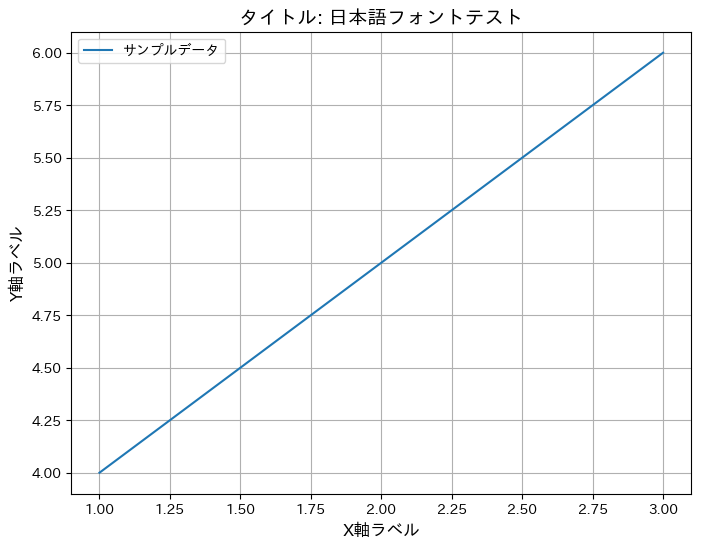

In [3]:
# 日本語を含むサンプルプロット
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3], [4, 5, 6], label='サンプルデータ')
plt.title('タイトル: 日本語フォントテスト', fontsize=14)
plt.xlabel('X軸ラベル', fontsize=12)
plt.ylabel('Y軸ラベル', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [4]:
df = pd.read_csv('/content/drive/MyDrive/卒研/需要予測/タケウチ/Data/seles10.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24716 entries, 0 to 24715
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   伝票日付    24716 non-null  object
 1   商品コード   24716 non-null  int64 
 2   商品名     24716 non-null  object
 3   入数      24716 non-null  int64 
 4   単価      24716 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 965.6+ KB


週次データへの変換

In [6]:
# 1. 伝票日付をdatetime型に変換
df['伝票日付'] = pd.to_datetime(df['伝票日付'], errors='coerce')

# 2. 各レコードに週情報を追加
df['週'] = df['伝票日付'].dt.to_period('W').dt.start_time

# 3. 商品名ごとに週次のデータを集計
# ここでは売上（単価 * 入数）を計算
df['売上'] = df['単価'] * df['入数']
weekly_data = df.groupby(['週', '商品名'])['売上'].sum().reset_index()

# 結果を確認
weekly_data

,週,商品名,売上
0,2020-11-02,キクロン Ａ,642480
1,2020-11-02,シュミテクト 歯周病ケア ９０ｇ,336096
2,2020-11-02,ジッポライタ―オイル １３３ＭＬ,5352
3,2020-11-02,ホ―ケン いきいき奥さん ３Ｐ,324000
4,2020-11-02,毎日香 黄箱 小型 バラ詰,162400
...,...,...,...
1925,2024-09-30,キクロン Ａ,88320
1926,2024-09-30,シュミテクト 歯周病ケア ９０ｇ,163656
1927,2024-09-30,ジッポライタ―オイル １３３ＭＬ,302400
1928,2024-09-30,毎日香 黄箱 小型 バラ詰,117600


 週次データの特徴量を作成

週次データをクラスタリングするには、適切な特徴量を作成する必要があります。

(1) 売上関連の特徴量

総売上 (sum)

平均売上 (mean)

売上の標準偏差（変動の大きさ）(std)

売上の最大値・最小値 (max, min)

(2) 時間関連の特徴量

週番号（1年の中での位置）

曜日（週末や平日の違い）

月（季節性を反映）

(3) 売上の変動特徴

売上増加率（前週からの変動割合）

移動平均（短期的なトレンドを考慮）


In [7]:
data = df
data

,伝票日付,商品コード,商品名,入数,単価,週,売上
0,2021-07-01,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600
1,2021-05-28,1550019,香樹林 大線香 バラ,60,1110,2021-05-24,66600
2,2021-12-13,1550019,香樹林 大線香 バラ,60,980,2021-12-13,58800
3,2023-12-11,1550019,香樹林 大線香 バラ,60,1260,2023-12-11,75600
4,2023-05-04,1550019,香樹林 大線香 バラ,60,989,2023-05-01,59340
...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880


In [8]:
# 週番号の追加
data['週番号'] = data['週'].dt.isocalendar().week  # ISO形式の週番号
data['月'] = data['週'].dt.month                 # 月
data['曜日'] = data['週'].dt.weekday
data

,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日
0,2021-07-01,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0
1,2021-05-28,1550019,香樹林 大線香 バラ,60,1110,2021-05-24,66600,21,5,0
2,2021-12-13,1550019,香樹林 大線香 バラ,60,980,2021-12-13,58800,50,12,0
3,2023-12-11,1550019,香樹林 大線香 バラ,60,1260,2023-12-11,75600,50,12,0
4,2023-05-04,1550019,香樹林 大線香 バラ,60,989,2023-05-01,59340,18,5,0
...,...,...,...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880,33,8,0
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400,8,2,0
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400,39,9,0
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880,31,8,0


In [9]:
# 季節情報を追加
def get_season(month):
    if month in [3, 4, 5]:
        return '春'
    elif month in [6, 7, 8]:
        return '夏'
    elif month in [9, 10, 11]:
        return '秋'
    else:
        return '冬'

data['季節'] = data['月'].apply(get_season)

# 祝日フラグ（サンプルとして特定の日付を祝日とする）
#holidays = ['2024-01-08', '2024-02-11']
#data['祝日フラグ'] = data['週'].isin(pd.to_datetime(holidays)).astype(int)

data

,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
0,2021-07-01,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0,夏
1,2021-05-28,1550019,香樹林 大線香 バラ,60,1110,2021-05-24,66600,21,5,0,春
2,2021-12-13,1550019,香樹林 大線香 バラ,60,980,2021-12-13,58800,50,12,0,冬
3,2023-12-11,1550019,香樹林 大線香 バラ,60,1260,2023-12-11,75600,50,12,0,冬
4,2023-05-04,1550019,香樹林 大線香 バラ,60,989,2023-05-01,59340,18,5,0,春
...,...,...,...,...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880,33,8,0,夏
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400,8,2,0,冬
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400,39,9,0,秋
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880,31,8,0,夏


## 辞書形式で、商品名ごとにデータフレームを分割する。

In [10]:
# 商品名ごとにデータフレームを分割（辞書形式）
dfs = {name: group for name, group in data.groupby('商品名')}

In [11]:
# 辞書の中身を確認
for name, df in dfs.items():
    print(f"商品名: {name}")
    display(df)

商品名: キクロン　Ａ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
21263,2023-02-03,2060041,キクロン Ａ,240,94,2023-01-30,22560,5,1,0,冬
21264,2023-11-07,2060041,キクロン Ａ,240,99,2023-11-06,23760,45,11,0,秋
21265,2020-12-07,2060041,キクロン Ａ,240,104,2020-12-07,24960,50,12,0,冬
21266,2020-11-06,2060041,キクロン Ａ,240,100,2020-11-02,24000,45,11,0,秋
21267,2021-10-20,2060041,キクロン Ａ,240,110,2021-10-18,26400,42,10,0,秋
...,...,...,...,...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880,33,8,0,夏
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400,8,2,0,冬
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400,39,9,0,秋
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880,31,8,0,夏


商品名: シュミテクト　歯周病ケア　９０ｇ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
12003,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,冬
12004,2023-10-03,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-10-02,32184,40,10,0,秋
12005,2023-03-22,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2023-03-20,36000,12,3,0,春
12006,2022-01-18,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-01-17,32184,3,1,0,冬
12007,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,冬
...,...,...,...,...,...,...,...,...,...,...,...
14110,2021-07-05,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2021-07-05,36000,27,7,0,夏
14111,2022-12-06,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-12-05,32184,49,12,0,冬
14112,2021-06-11,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2021-06-07,36000,23,6,0,夏
14113,2023-04-04,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-04-03,32184,14,4,0,春


商品名: ジッポライタ―オイル　１３３ＭＬ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
15546,2024-04-12,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-04-08,44352,15,4,0,春
15547,2024-03-15,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-03-11,44352,11,3,0,春
15548,2024-06-10,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-06-10,43200,24,6,0,夏
15549,2024-01-29,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-01-29,44352,5,1,0,冬
15550,2024-09-23,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-09-23,43200,39,9,0,秋
...,...,...,...,...,...,...,...,...,...,...,...
18989,2022-07-01,4010001,ジッポライタ―オイル １３３ＭＬ,24,250,2022-06-27,6000,26,6,0,夏
18990,2024-02-12,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-02-12,44352,7,2,0,冬
18991,2024-05-20,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-05-20,43200,21,5,0,春
18992,2022-04-04,4010001,ジッポライタ―オイル １３３ＭＬ,24,250,2022-04-04,6000,14,4,0,春


商品名: ホ―ケン　いきいき奥さん　３Ｐ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
4885,2021-01-26,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2021-01-25,36000,4,1,0,冬
4886,2020-11-03,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2020-11-02,36000,45,11,0,秋
4887,2022-07-05,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-07-04,36000,27,7,0,夏
4888,2021-10-19,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2021-10-18,36000,42,10,0,秋
4889,2023-01-10,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2023-01-09,36000,2,1,0,冬
...,...,...,...,...,...,...,...,...,...,...,...
6585,2022-06-21,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-06-20,36000,25,6,0,夏
6586,2024-07-23,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2024-07-22,36000,30,7,0,夏
6587,2022-02-15,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-02-14,36000,7,2,0,冬
6588,2022-12-20,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-12-19,36000,51,12,0,冬


商品名: 毎日香　黄箱　小型　バラ詰


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
9705,2024-06-27,1520132,毎日香 黄箱 小型 バラ詰,100,294,2024-06-24,29400,26,6,0,夏
9706,2021-11-05,1520132,毎日香 黄箱 小型 バラ詰,100,266,2021-11-01,26600,44,11,0,秋
9707,2023-07-20,1520132,毎日香 黄箱 小型 バラ詰,100,330,2023-07-17,33000,29,7,0,夏
9708,2022-09-16,1520132,毎日香 黄箱 小型 バラ詰,100,266,2022-09-12,26600,37,9,0,秋
9709,2023-07-24,1520132,毎日香 黄箱 小型 バラ詰,100,294,2023-07-24,29400,30,7,0,夏
...,...,...,...,...,...,...,...,...,...,...,...
11998,2022-06-06,1520132,毎日香 黄箱 小型 バラ詰,100,266,2022-06-06,26600,23,6,0,夏
11999,2023-08-03,1520132,毎日香 黄箱 小型 バラ詰,100,327,2023-07-31,32700,31,7,0,夏
12000,2024-09-06,1520132,毎日香 黄箱 小型 バラ詰,100,294,2024-09-02,29400,36,9,0,秋
12001,2021-09-24,1520132,毎日香 黄箱 小型 バラ詰,100,266,2021-09-20,26600,38,9,0,秋


商品名: 虎マッチ　並型　１２Ｐ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
839,2021-06-10,1560022,虎マッチ 並型 １２Ｐ,100,150,2021-06-07,15000,23,6,0,夏
840,2023-02-02,1560022,虎マッチ 並型 １２Ｐ,100,150,2023-01-30,15000,5,1,0,冬
841,2021-06-22,1560022,虎マッチ 並型 １２Ｐ,100,128,2021-06-21,12800,25,6,0,夏
842,2020-12-07,1560022,虎マッチ 並型 １２Ｐ,100,142,2020-12-07,14200,50,12,0,冬
843,2023-10-09,1560022,虎マッチ 並型 １２Ｐ,100,165,2023-10-09,16500,41,10,0,秋
...,...,...,...,...,...,...,...,...,...,...,...
4880,2023-01-19,1560022,虎マッチ 並型 １２Ｐ,100,140,2023-01-16,14000,3,1,0,冬
4881,2022-06-30,1560022,虎マッチ 並型 １２Ｐ,100,150,2022-06-27,15000,26,6,0,夏
4882,2021-09-09,1560022,虎マッチ 並型 １２Ｐ,100,142,2021-09-06,14200,36,9,0,秋
4883,2022-02-28,1560022,虎マッチ 並型 １２Ｐ,100,150,2022-02-28,15000,9,2,0,冬


商品名: 青雲バイオレット　バラ詰１２５ｇ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
18994,2022-08-04,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2022-08-01,35100,31,8,0,夏
18995,2022-11-14,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2022-11-14,35100,46,11,0,秋
18996,2023-07-17,1520137,青雲バイオレット バラ詰１２５ｇ,60,743,2023-07-17,44580,29,7,0,夏
18997,2023-01-19,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2023-01-16,35100,3,1,0,冬
18998,2024-09-16,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2024-09-16,39600,38,9,0,秋
...,...,...,...,...,...,...,...,...,...,...,...
21258,2024-08-19,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2024-08-19,39600,34,8,0,夏
21259,2022-03-18,1520137,青雲バイオレット バラ詰１２５ｇ,60,586,2022-03-14,35160,11,3,0,春
21260,2023-01-12,1520137,青雲バイオレット バラ詰１２５ｇ,60,675,2023-01-09,40500,2,1,0,冬
21261,2023-08-07,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2023-08-07,39600,32,8,0,夏


商品名: 香樹林　大線香　バラ


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
0,2021-07-01,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0,夏
1,2021-05-28,1550019,香樹林 大線香 バラ,60,1110,2021-05-24,66600,21,5,0,春
2,2021-12-13,1550019,香樹林 大線香 バラ,60,980,2021-12-13,58800,50,12,0,冬
3,2023-12-11,1550019,香樹林 大線香 バラ,60,1260,2023-12-11,75600,50,12,0,冬
4,2023-05-04,1550019,香樹林 大線香 バラ,60,989,2023-05-01,59340,18,5,0,春
...,...,...,...,...,...,...,...,...,...,...,...
834,2024-08-05,1550019,香樹林 大線香 バラ,60,1260,2024-08-05,75600,32,8,0,夏
835,2022-07-21,1550019,香樹林 大線香 バラ,60,989,2022-07-18,59340,29,7,0,夏
836,2021-06-30,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0,夏
837,2021-02-26,1550019,香樹林 大線香 バラ,60,1110,2021-02-22,66600,8,2,0,冬


商品名: ＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
14194,2023-10-30,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-30,48480,44,10,0,秋
14294,2023-08-29,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2023-08-28,54000,35,8,0,夏
14344,2023-08-21,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-08-21,48480,34,8,0,夏
14376,2023-10-26,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-23,48480,43,10,0,秋
14406,2023-11-06,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-11-06,48480,45,11,0,秋
14415,2023-09-18,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-18,45600,38,9,0,秋
14421,2023-09-18,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-09-18,48480,38,9,0,秋
14491,2023-09-25,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-25,45600,39,9,0,秋
14647,2023-10-12,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-09,48480,41,10,0,秋
14654,2023-09-07,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-04,45600,36,9,0,秋


商品名: ＲＳ－１９９　つま楊枝　５００本


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
6590,2024-04-16,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2024-04-15,17920,16,4,0,春
6591,2022-07-07,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2022-07-04,20160,27,7,0,夏
6592,2023-03-31,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2023-03-27,17920,13,3,0,春
6593,2021-02-02,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2021-02-01,17920,5,2,0,冬
6594,2023-12-22,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2023-12-18,17920,51,12,0,冬
...,...,...,...,...,...,...,...,...,...,...,...
9700,2023-04-10,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2023-04-10,20160,15,4,0,春
9701,2024-07-30,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,88,2024-07-29,24640,31,7,0,夏
9702,2023-01-19,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2023-01-16,20160,3,1,0,冬
9703,2021-08-23,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,68,2021-08-23,19040,34,8,0,夏


商品名: ＲＳ３７Ｌ　ＨＢマスク　普通６枚


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節
14115,2023-03-01,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2023-02-27,54000,9,2,0,冬
14116,2021-07-05,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2021-07-05,45600,27,7,0,夏
14117,2022-04-21,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2022-04-18,54000,16,4,0,春
14118,2021-07-06,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2021-07-05,48480,27,7,0,夏
14119,2023-02-03,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-01-30,45600,5,1,0,冬
...,...,...,...,...,...,...,...,...,...,...,...
15540,2022-03-31,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2022-03-28,54000,13,3,0,春
15541,2022-09-26,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2022-09-26,45600,39,9,0,秋
15542,2021-09-03,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2021-08-30,45600,35,8,0,夏
15544,2020-12-01,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2020-11-30,45600,49,11,0,秋


ランダムフォレストする前に正規化したほうが良かったかも

In [12]:
from sklearn.ensemble import RandomForestRegressor
# 商品ごとに処理
results = {}
for name, df in dfs.items():
    # 売上変化率
    df['売上変化率'] = df['売上'].pct_change().fillna(0)

    # 移動平均（過去3週分）
    df['移動平均'] = df['売上'].rolling(window=3).mean().fillna(0)

    # 売上の累積値
    df['累積売上'] = df['売上'].cumsum()
        # 更新後のデータフレームを辞書に戻す
    dfs[name] = df

    # モデルのトレーニング
    X = df[['週番号', '月', '売上変化率', '移動平均']]
    y = df['売上']
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    # 特徴量の重要度を取得
    feature_importances = model.feature_importances_

    # 結果を辞書に保存
    results[name] = {
        'モデル': model,
        '特徴量重要度': feature_importances,
        'データフレーム': df
    }

# 商品ごとの結果を確認
for name, result in results.items():
    print(f"商品名: {name}")
    print("特徴量重要度:", result['特徴量重要度'])
    display(result['データフレーム'])
    print("-" * 40)

商品名: キクロン　Ａ
特徴量重要度: [0.02405186 0.00903658 0.63453265 0.33237891]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
21263,2023-02-03,2060041,キクロン Ａ,240,94,2023-01-30,22560,5,1,0,冬,0.000000,0.0,22560
21264,2023-11-07,2060041,キクロン Ａ,240,99,2023-11-06,23760,45,11,0,秋,0.053191,0.0,46320
21265,2020-12-07,2060041,キクロン Ａ,240,104,2020-12-07,24960,50,12,0,冬,0.050505,23760.0,71280
21266,2020-11-06,2060041,キクロン Ａ,240,100,2020-11-02,24000,45,11,0,秋,-0.038462,24240.0,95280
21267,2021-10-20,2060041,キクロン Ａ,240,110,2021-10-18,26400,42,10,0,秋,0.100000,25120.0,121680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880,33,8,0,夏,0.018182,26560.0,89647440
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400,8,2,0,冬,-0.017857,26560.0,89673840
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400,39,9,0,秋,0.000000,26560.0,89700240
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880,31,8,0,夏,0.018182,26560.0,89727120


----------------------------------------
商品名: シュミテクト　歯周病ケア　９０ｇ
特徴量重要度: [2.11924579e-03 3.88864212e-04 7.23502008e-01 2.73989882e-01]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
12003,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,冬,0.000000,0.0,32184
12004,2023-10-03,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-10-02,32184,40,10,0,秋,0.000000,0.0,64368
12005,2023-03-22,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2023-03-20,36000,12,3,0,春,0.118568,33456.0,100368
12006,2022-01-18,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-01-17,32184,3,1,0,冬,-0.106000,33456.0,132552
12007,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,冬,0.000000,33456.0,164736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14110,2021-07-05,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2021-07-05,36000,27,7,0,夏,0.118568,34728.0,70835472
14111,2022-12-06,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-12-05,32184,49,12,0,冬,-0.106000,33456.0,70867656
14112,2021-06-11,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2021-06-07,36000,23,6,0,夏,0.118568,34728.0,70903656
14113,2023-04-04,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-04-03,32184,14,4,0,春,-0.106000,33456.0,70935840


----------------------------------------
商品名: ジッポライタ―オイル　１３３ＭＬ
特徴量重要度: [4.22245318e-04 1.31045604e-04 6.38285455e-01 3.61161255e-01]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
15546,2024-04-12,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-04-08,44352,15,4,0,春,0.000000,0.0,44352
15547,2024-03-15,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-03-11,44352,11,3,0,春,0.000000,0.0,88704
15548,2024-06-10,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-06-10,43200,24,6,0,夏,-0.025974,43968.0,131904
15549,2024-01-29,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-01-29,44352,5,1,0,冬,0.026667,43968.0,176256
15550,2024-09-23,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-09-23,43200,39,9,0,秋,-0.025974,43584.0,219456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18989,2022-07-01,4010001,ジッポライタ―オイル １３３ＭＬ,24,250,2022-06-27,6000,26,6,0,夏,0.262626,8264.0,74354856
18990,2024-02-12,4010001,ジッポライタ―オイル １３３ＭＬ,96,462,2024-02-12,44352,7,2,0,冬,6.392000,18368.0,74399208
18991,2024-05-20,4010001,ジッポライタ―オイル １３３ＭＬ,96,450,2024-05-20,43200,21,5,0,春,-0.025974,31184.0,74442408
18992,2022-04-04,4010001,ジッポライタ―オイル １３３ＭＬ,24,250,2022-04-04,6000,14,4,0,春,-0.861111,31184.0,74448408


----------------------------------------
商品名: ホ―ケン　いきいき奥さん　３Ｐ
特徴量重要度: [0.00395373 0.00209274 0.90528375 0.08866979]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
4885,2021-01-26,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2021-01-25,36000,4,1,0,冬,0.0,0.0,36000
4886,2020-11-03,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2020-11-02,36000,45,11,0,秋,0.0,0.0,72000
4887,2022-07-05,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-07-04,36000,27,7,0,夏,0.0,36000.0,108000
4888,2021-10-19,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2021-10-18,36000,42,10,0,秋,0.0,36000.0,144000
4889,2023-01-10,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2023-01-09,36000,2,1,0,冬,0.0,36000.0,180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585,2022-06-21,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-06-20,36000,25,6,0,夏,0.0,36000.0,61162000
6586,2024-07-23,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2024-07-22,36000,30,7,0,夏,0.0,36000.0,61198000
6587,2022-02-15,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-02-14,36000,7,2,0,冬,0.0,36000.0,61234000
6588,2022-12-20,4060029,ホ―ケン いきいき奥さん ３Ｐ,100,360,2022-12-19,36000,51,12,0,冬,0.0,36000.0,61270000


----------------------------------------
商品名: 毎日香　黄箱　小型　バラ詰
特徴量重要度: [0.00661952 0.00223689 0.65629981 0.33484378]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
9705,2024-06-27,1520132,毎日香 黄箱 小型 バラ詰,100,294,2024-06-24,29400,26,6,0,夏,0.000000,0.000000,29400
9706,2021-11-05,1520132,毎日香 黄箱 小型 バラ詰,100,266,2021-11-01,26600,44,11,0,秋,-0.095238,0.000000,56000
9707,2023-07-20,1520132,毎日香 黄箱 小型 バラ詰,100,330,2023-07-17,33000,29,7,0,夏,0.240602,29666.666667,89000
9708,2022-09-16,1520132,毎日香 黄箱 小型 バラ詰,100,266,2022-09-12,26600,37,9,0,秋,-0.193939,28733.333333,115600
9709,2023-07-24,1520132,毎日香 黄箱 小型 バラ詰,100,294,2023-07-24,29400,30,7,0,夏,0.105263,29666.666667,145000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11998,2022-06-06,1520132,毎日香 黄箱 小型 バラ詰,100,266,2022-06-06,26600,23,6,0,夏,-0.095238,28566.666667,65644900
11999,2023-08-03,1520132,毎日香 黄箱 小型 バラ詰,100,327,2023-07-31,32700,31,7,0,夏,0.229323,29566.666667,65677600
12000,2024-09-06,1520132,毎日香 黄箱 小型 バラ詰,100,294,2024-09-02,29400,36,9,0,秋,-0.100917,29566.666667,65707000
12001,2021-09-24,1520132,毎日香 黄箱 小型 バラ詰,100,266,2021-09-20,26600,38,9,0,秋,-0.095238,29566.666667,65733600


----------------------------------------
商品名: 虎マッチ　並型　１２Ｐ
特徴量重要度: [0.00565263 0.00187042 0.77459039 0.21788656]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
839,2021-06-10,1560022,虎マッチ 並型 １２Ｐ,100,150,2021-06-07,15000,23,6,0,夏,0.000000,0.000000,15000
840,2023-02-02,1560022,虎マッチ 並型 １２Ｐ,100,150,2023-01-30,15000,5,1,0,冬,0.000000,0.000000,30000
841,2021-06-22,1560022,虎マッチ 並型 １２Ｐ,100,128,2021-06-21,12800,25,6,0,夏,-0.146667,14266.666667,42800
842,2020-12-07,1560022,虎マッチ 並型 １２Ｐ,100,142,2020-12-07,14200,50,12,0,冬,0.109375,14000.000000,57000
843,2023-10-09,1560022,虎マッチ 並型 １２Ｐ,100,165,2023-10-09,16500,41,10,0,秋,0.161972,14500.000000,73500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4880,2023-01-19,1560022,虎マッチ 並型 １２Ｐ,100,140,2023-01-16,14000,3,1,0,冬,-0.151515,14433.333333,58592600
4881,2022-06-30,1560022,虎マッチ 並型 １２Ｐ,100,150,2022-06-27,15000,26,6,0,夏,0.071429,15166.666667,58607600
4882,2021-09-09,1560022,虎マッチ 並型 １２Ｐ,100,142,2021-09-06,14200,36,9,0,秋,-0.053333,14400.000000,58621800
4883,2022-02-28,1560022,虎マッチ 並型 １２Ｐ,100,150,2022-02-28,15000,9,2,0,冬,0.056338,14733.333333,58636800


----------------------------------------
商品名: 青雲バイオレット　バラ詰１２５ｇ
特徴量重要度: [0.00407818 0.00155701 0.70398065 0.29038417]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
18994,2022-08-04,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2022-08-01,35100,31,8,0,夏,0.000000,0.0,35100
18995,2022-11-14,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2022-11-14,35100,46,11,0,秋,0.000000,0.0,70200
18996,2023-07-17,1520137,青雲バイオレット バラ詰１２５ｇ,60,743,2023-07-17,44580,29,7,0,夏,0.270085,38260.0,114780
18997,2023-01-19,1520137,青雲バイオレット バラ詰１２５ｇ,60,585,2023-01-16,35100,3,1,0,冬,-0.212651,38260.0,149880
18998,2024-09-16,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2024-09-16,39600,38,9,0,秋,0.128205,39760.0,189480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,2024-08-19,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2024-08-19,39600,34,8,0,夏,0.126280,38120.0,85747140
21259,2022-03-18,1520137,青雲バイオレット バラ詰１２５ｇ,60,586,2022-03-14,35160,11,3,0,春,-0.112121,36640.0,85782300
21260,2023-01-12,1520137,青雲バイオレット バラ詰１２５ｇ,60,675,2023-01-09,40500,2,1,0,冬,0.151877,38420.0,85822800
21261,2023-08-07,1520137,青雲バイオレット バラ詰１２５ｇ,60,660,2023-08-07,39600,32,8,0,夏,-0.022222,38420.0,85862400


----------------------------------------
商品名: 香樹林　大線香　バラ
特徴量重要度: [0.00920433 0.00349683 0.69277579 0.29452306]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
0,2021-07-01,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0,夏,0.000000,0.0,75600
1,2021-05-28,1550019,香樹林 大線香 バラ,60,1110,2021-05-24,66600,21,5,0,春,-0.119048,0.0,142200
2,2021-12-13,1550019,香樹林 大線香 バラ,60,980,2021-12-13,58800,50,12,0,冬,-0.117117,67000.0,201000
3,2023-12-11,1550019,香樹林 大線香 バラ,60,1260,2023-12-11,75600,50,12,0,冬,0.285714,67000.0,276600
4,2023-05-04,1550019,香樹林 大線香 バラ,60,989,2023-05-01,59340,18,5,0,春,-0.215079,64580.0,335940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,2024-08-05,1550019,香樹林 大線香 バラ,60,1260,2024-08-05,75600,32,8,0,夏,0.135135,69600.0,56066700
835,2022-07-21,1550019,香樹林 大線香 バラ,60,989,2022-07-18,59340,29,7,0,夏,-0.215079,67180.0,56126040
836,2021-06-30,1550019,香樹林 大線香 バラ,60,1260,2021-06-28,75600,26,6,0,夏,0.274014,70180.0,56201640
837,2021-02-26,1550019,香樹林 大線香 バラ,60,1110,2021-02-22,66600,8,2,0,冬,-0.119048,67180.0,56268240


----------------------------------------
商品名: ＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚
特徴量重要度: [0.18429974 0.1170711  0.53230572 0.16632344]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
14194,2023-10-30,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-30,48480,44,10,0,秋,0.000000,0.0,48480
14294,2023-08-29,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2023-08-28,54000,35,8,0,夏,0.113861,0.0,102480
14344,2023-08-21,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-08-21,48480,34,8,0,夏,-0.102222,50320.0,150960
14376,2023-10-26,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-23,48480,43,10,0,秋,0.000000,50320.0,199440
14406,2023-11-06,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-11-06,48480,45,11,0,秋,0.000000,48480.0,247920
14415,2023-09-18,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-18,45600,38,9,0,秋,-0.059406,47520.0,293520
14421,2023-09-18,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-09-18,48480,38,9,0,秋,0.063158,47520.0,342000
14491,2023-09-25,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-25,45600,39,9,0,秋,-0.059406,46560.0,387600
14647,2023-10-12,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2023-10-09,48480,41,10,0,秋,0.063158,47520.0,436080
14654,2023-09-07,3970022,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-09-04,45600,36,9,0,秋,-0.059406,46560.0,481680


----------------------------------------
商品名: ＲＳ－１９９　つま楊枝　５００本
特徴量重要度: [0.01056865 0.00356827 0.7981629  0.18770017]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
6590,2024-04-16,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2024-04-15,17920,16,4,0,春,0.000000,0.000000,17920
6591,2022-07-07,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2022-07-04,20160,27,7,0,夏,0.125000,0.000000,38080
6592,2023-03-31,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2023-03-27,17920,13,3,0,春,-0.111111,18666.666667,56000
6593,2021-02-02,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2021-02-01,17920,5,2,0,冬,0.000000,18666.666667,73920
6594,2023-12-22,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,64,2023-12-18,17920,51,12,0,冬,0.000000,17920.000000,91840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,2023-04-10,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2023-04-10,20160,15,4,0,春,0.000000,20160.000000,61465600
9701,2024-07-30,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,88,2024-07-29,24640,31,7,0,夏,0.222222,21653.333333,61490240
9702,2023-01-19,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,72,2023-01-16,20160,3,1,0,冬,-0.181818,21653.333333,61510400
9703,2021-08-23,4040085,ＲＳ－１９９ つま楊枝 ５００本,280,68,2021-08-23,19040,34,8,0,夏,-0.055556,21280.000000,61529440


----------------------------------------
商品名: ＲＳ３７Ｌ　ＨＢマスク　普通６枚
特徴量重要度: [1.13858282e-03 7.30854014e-04 8.46082054e-01 1.52048509e-01]


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
14115,2023-03-01,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2023-02-27,54000,9,2,0,冬,0.000000,0.0,54000
14116,2021-07-05,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2021-07-05,45600,27,7,0,夏,-0.155556,0.0,99600
14117,2022-04-21,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2022-04-18,54000,16,4,0,春,0.184211,51200.0,153600
14118,2021-07-06,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,202,2021-07-05,48480,27,7,0,夏,-0.102222,49360.0,202080
14119,2023-02-03,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2023-01-30,45600,5,1,0,冬,-0.059406,49360.0,247680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15540,2022-03-31,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,225,2022-03-28,54000,13,3,0,春,0.184211,56560.0,70216080
15541,2022-09-26,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2022-09-26,45600,39,9,0,秋,-0.155556,48400.0,70261680
15542,2021-09-03,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2021-08-30,45600,35,8,0,夏,0.000000,48400.0,70307280
15544,2020-12-01,3970022,ＲＳ３７Ｌ ＨＢマスク 普通６枚,240,190,2020-11-30,45600,49,11,0,秋,0.000000,45600.0,70352880


----------------------------------------


特徴量重要度が高かったもの（週番号、月、売上変化率、移動平均）

キクロン：売上

ジッポライター：どれも低い

ホーくん生き生き奥さん：売上、移動平均

毎日香：売上、移動

虎マッチ：売上、移動


青くも：売上、移動

香木林：売上、移動

RS37-HBマスク：全部

RS-199爪楊枝：売上、移動

RS-37L HBマスク：どれも低い

# クロス集計（商品名を列に変換）<br>
2つ以上のカテゴリ変数のデータを比較し、関係性や分布を明らかにするために集計方法

In [13]:
# 商品名を列として持つデータフレームに変換
weekly_pivot = weekly_data.pivot(index='週', columns='商品名', values='売上').fillna(0)

# 結果を確認
weekly_pivot

商品名,キクロン Ａ,シュミテクト 歯周病ケア ９０ｇ,ジッポライタ―オイル １３３ＭＬ,ホ―ケン いきいき奥さん ３Ｐ,毎日香 黄箱 小型 バラ詰,虎マッチ 並型 １２Ｐ,青雲バイオレット バラ詰１２５ｇ,香樹林 大線香 バラ,＊ＲＳ３７Ｌ ＨＢマスク 普通６枚,ＲＳ－１９９ つま楊枝 ５００本,ＲＳ３７Ｌ ＨＢマスク 普通６枚
週,,,,,,,,,,,
2020-11-02,642480.0,336096.0,5352.0,324000.0,162400.0,311900.0,0.0,327120.0,0.0,394240.0,435840.0
2020-11-09,491040.0,403992.0,18192.0,287000.0,305000.0,390500.0,0.0,251400.0,0.0,311080.0,612720.0
2020-11-16,374400.0,367848.0,30048.0,360000.0,387600.0,262900.0,0.0,67200.0,0.0,345800.0,780480.0
2020-11-23,470880.0,280368.0,29112.0,360000.0,215000.0,227600.0,0.0,496800.0,0.0,234360.0,586800.0
2020-11-30,400800.0,298368.0,6720.0,431000.0,380800.0,375000.0,0.0,246000.0,0.0,366800.0,615600.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-02,520800.0,430560.0,432000.0,324000.0,271800.0,225700.0,517320.0,142200.0,0.0,255080.0,0.0
2024-09-09,326640.0,294768.0,342720.0,252000.0,282600.0,235200.0,199440.0,0.0,0.0,289520.0,0.0
2024-09-16,403920.0,375840.0,518400.0,210000.0,354000.0,192000.0,466980.0,270000.0,0.0,247800.0,0.0


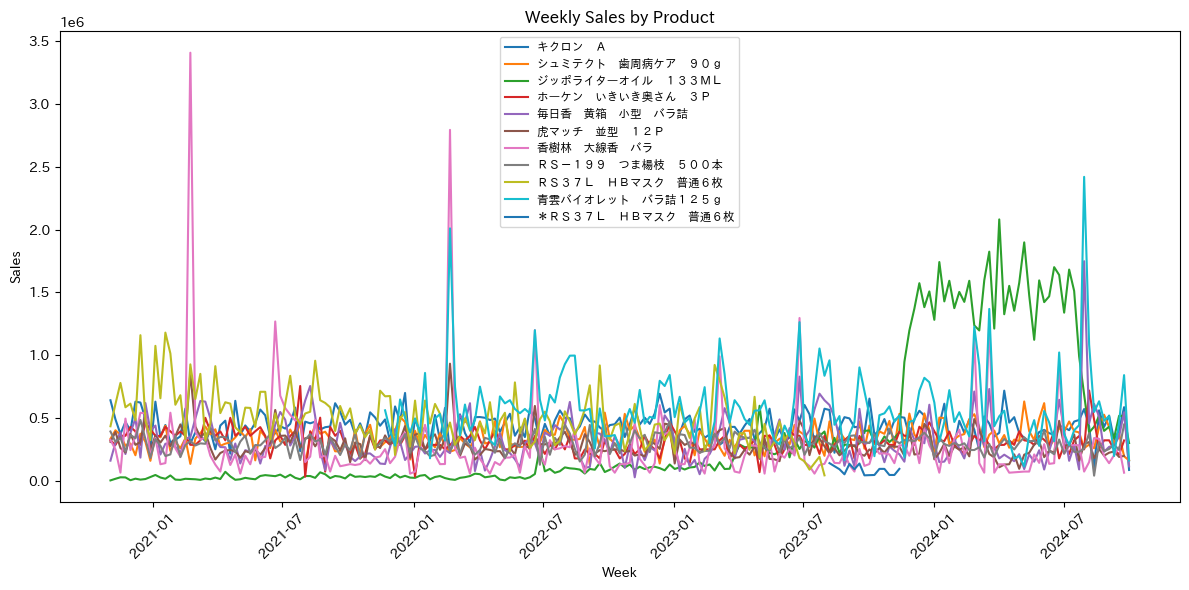

In [14]:
# 商品名ごとの週次売上をグラフ化
plt.figure(figsize=(12, 6))
for product_name in weekly_data['商品名'].unique():
    product_data = weekly_data[weekly_data['商品名'] == product_name]
    plt.plot(product_data['週'], product_data['売上'], label=product_name)

plt.title('Weekly Sales by Product')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend(loc='best', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

正規化が必要？


*   データのスケールが異なる場合
*   時系列データ感の比較を行う場合
*   モデルのトレーニング前
*   異なる期間のデータを比較する場合







In [15]:
from sklearn.preprocessing import StandardScaler

# 特徴量を選択
features = ['売上変化率', '移動平均', '累積売上']
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[features])

In [16]:
normalized_data

array([[ -0.08780262, -10.44866705,  -1.72641398],
       [ -0.91248047, -10.44866705,  -1.72417816],
       [  0.88878957,   0.25812198,  -1.72153049],
       ...,
       [ -0.08780262,  -0.32740554,   1.71817807],
       [ -0.08780262,  -0.91293307,   1.72041388],
       [ -0.08780262,  -0.91293307,   1.7226497 ]])

In [17]:
for name, df in dfs.items():
    print(f"商品名: {name}")
    print("カラム一覧:", df.columns)
    print("データ内容:")
    print(df.head())
    print("-" * 40)

商品名: キクロン　Ａ
カラム一覧: Index(['伝票日付', '商品コード', '商品名', '入数', '単価', '週', '売上', '週番号', '月', '曜日', '季節',
       '売上変化率', '移動平均', '累積売上'],
      dtype='object')
データ内容:
            伝票日付    商品コード     商品名   入数   単価          週     売上  週番号   月  曜日 季節  \
21263 2023-02-03  2060041  キクロン　Ａ  240   94 2023-01-30  22560    5   1   0  冬   
21264 2023-11-07  2060041  キクロン　Ａ  240   99 2023-11-06  23760   45  11   0  秋   
21265 2020-12-07  2060041  キクロン　Ａ  240  104 2020-12-07  24960   50  12   0  冬   
21266 2020-11-06  2060041  キクロン　Ａ  240  100 2020-11-02  24000   45  11   0  秋   
21267 2021-10-20  2060041  キクロン　Ａ  240  110 2021-10-18  26400   42  10   0  秋   

          売上変化率     移動平均    累積売上  
21263  0.000000      0.0   22560  
21264  0.053191      0.0   46320  
21265  0.050505  23760.0   71280  
21266 -0.038462  24240.0   95280  
21267  0.100000  25120.0  121680  
----------------------------------------
商品名: シュミテクト　歯周病ケア　９０ｇ
カラム一覧: Index(['伝票日付', '商品コード', '商品名', '入数', '単価', '週', '売上', '週番号', '月', '曜日', '季

In [18]:
# 標準化されたデータを格納する辞書
normalized_dicts = {}

# 各辞書に対して処理
for name, data in dfs.items():
    # 辞書内のデータを DataFrame に変換
    df = pd.DataFrame(data).T  # 行と列を入れ替え
    df.reset_index(inplace=True)
    df.rename(columns={"index": "商品名"}, inplace=True)

    # 特徴量を選択
    features = ['売上変化率', '移動平均', '累積売上']

    # 特徴量が存在するかチェックして処理
    if all(feature in df.columns for feature in features):
        # 特徴量を標準化
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(df[features])

        # 標準化したデータを DataFrame に格納
        normalized_df = pd.DataFrame(normalized_features, columns=features)
        normalized_df['商品名'] = df['商品名'].values  # 商品名を保持

        # 結果を辞書に保存
        normalized_dicts[name] = normalized_df
    else:
        print(f"Warning: Missing features in {name}. Skipping...")

# 確認
for name, normalized_df in normalized_dicts.items():
    print(f"=== {name} ===")
    print(normalized_df)


In [19]:
from sklearn.preprocessing import StandardScaler

# 標準化されたデータを格納する辞書
normalized_dicts = {}

# 各辞書に対して処理
for name, data in dfs.items():
    # 辞書内のデータを DataFrame に変換
    df = pd.DataFrame(data).T
    df.reset_index(inplace=True)
    df.rename(columns={"index": "商品名"}, inplace=True)

    # 必要なカラムの作成
    if '売上' in df.columns:
        df['売上変化率'] = df['売上'].pct_change().fillna(0)
        df['移動平均'] = df['売上'].rolling(window=3).mean().fillna(0)
        df['累積売上'] = df['売上'].cumsum()
    else:
        print(f"商品名: {name} に '売上' カラムがありません。スキップします。")
        continue

    # 特徴量を選択
    features = ['売上変化率', '移動平均', '累積売上']

    # データの検証
    for feature in features:
        if df[feature].nunique() <= 1:
            print(f"商品名: {name}, カラム: {feature} のデータが均一です。スキップします。")
            continue

    # 特徴量を標準化
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df[features])

    # 標準化したデータを DataFrame に格納
    normalized_df = pd.DataFrame(normalized_features, columns=features)
    normalized_df['商品名'] = df['商品名'].values

    # 結果を辞書に保存
    normalized_dicts[name] = normalized_df

# 結果を確認
for name, normalized_df in normalized_dicts.items():
    print(f"=== {name} ===")
    print(normalized_df)


商品名: キクロン　Ａ に '売上' カラムがありません。スキップします。
商品名: シュミテクト　歯周病ケア　９０ｇ に '売上' カラムがありません。スキップします。
商品名: ジッポライタ―オイル　１３３ＭＬ に '売上' カラムがありません。スキップします。
商品名: ホ―ケン　いきいき奥さん　３Ｐ に '売上' カラムがありません。スキップします。
商品名: 毎日香　黄箱　小型　バラ詰 に '売上' カラムがありません。スキップします。
商品名: 虎マッチ　並型　１２Ｐ に '売上' カラムがありません。スキップします。
商品名: 青雲バイオレット　バラ詰１２５ｇ に '売上' カラムがありません。スキップします。
商品名: 香樹林　大線香　バラ に '売上' カラムがありません。スキップします。
商品名: ＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚 に '売上' カラムがありません。スキップします。
商品名: ＲＳ－１９９　つま楊枝　５００本 に '売上' カラムがありません。スキップします。
商品名: ＲＳ３７Ｌ　ＨＢマスク　普通６枚 に '売上' カラムがありません。スキップします。


なんでできないんだろ？

In [20]:
# 各データフレームで欠けている特徴量を表示
for name, data in dfs.items():
    df = pd.DataFrame(data).T
    df.reset_index(inplace=True)
    missing_features = [feature for feature in ['売上変化率', '移動平均', '累積売上'] if feature not in df.columns]
    if missing_features:
        print(f"{name} is missing: {missing_features}")


キクロン　Ａ is missing: ['売上変化率', '移動平均', '累積売上']
シュミテクト　歯周病ケア　９０ｇ is missing: ['売上変化率', '移動平均', '累積売上']
ジッポライタ―オイル　１３３ＭＬ is missing: ['売上変化率', '移動平均', '累積売上']
ホ―ケン　いきいき奥さん　３Ｐ is missing: ['売上変化率', '移動平均', '累積売上']
毎日香　黄箱　小型　バラ詰 is missing: ['売上変化率', '移動平均', '累積売上']
虎マッチ　並型　１２Ｐ is missing: ['売上変化率', '移動平均', '累積売上']
青雲バイオレット　バラ詰１２５ｇ is missing: ['売上変化率', '移動平均', '累積売上']
香樹林　大線香　バラ is missing: ['売上変化率', '移動平均', '累積売上']
＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚 is missing: ['売上変化率', '移動平均', '累積売上']
ＲＳ－１９９　つま楊枝　５００本 is missing: ['売上変化率', '移動平均', '累積売上']
ＲＳ３７Ｌ　ＨＢマスク　普通６枚 is missing: ['売上変化率', '移動平均', '累積売上']


# クラスタリング

データを類似したグループに分けることで、予測精度を向上させたり、個別の特徴を分析すること

・商品ごと: 高単価商品と低単価商品のグループ分け。

・時間軸ごと: 季節性や特定の週に売上が偏る商品。

・販売パターンごと: 毎日売れる商品 vs イベント時のみ売れる商品。

クラスタリングすることで、各グループに応じた予測モデルを構築でき、全体的な予測精度が向上します。

静的クラスタリング

特徴量を集約した後、通常のクラスタリング手法を適用します。


K-Means


階層型クラスタリング

DBSCAN

(2) 動的時系列クラスタリング

時系列データそのものの形状や変動パターンを比較します。



DTW（Dynamic Time Warping）を利用

異なる長さの時系列データも比較可能。

tslearnライブラリを使用。

Shape-Based Clustering

時系列データの形状をそのままクラスタリングします。


DTWはクラスタリングそのものではなく、距離計算の手法。2つの時系列データ感の類似度や距離を測定するために使用されるが、クラスタリングを直接行うアルゴリズムではない。

# もういいから一つずつやりまーす

GPTによるクラスタリング対象の特徴量例

・売上変化率

・移動平均

・累積売上

・季節


# キクロン　A

In [21]:
# 辞書の中から1つだけ取り出す。
key = 'キクロン　Ａ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")


            伝票日付    商品コード     商品名   入数   単価          週     売上  週番号   月  曜日 季節  \
21263 2023-02-03  2060041  キクロン　Ａ  240   94 2023-01-30  22560    5   1   0  冬   
21264 2023-11-07  2060041  キクロン　Ａ  240   99 2023-11-06  23760   45  11   0  秋   
21265 2020-12-07  2060041  キクロン　Ａ  240  104 2020-12-07  24960   50  12   0  冬   
21266 2020-11-06  2060041  キクロン　Ａ  240  100 2020-11-02  24000   45  11   0  秋   
21267 2021-10-20  2060041  キクロン　Ａ  240  110 2021-10-18  26400   42  10   0  秋   
...          ...      ...     ...  ...  ...        ...    ...  ...  ..  .. ..   
24711 2021-08-16  2060041  キクロン　Ａ  240  112 2021-08-16  26880   33   8   0  夏   
24712 2023-02-24  2060041  キクロン　Ａ  240  110 2023-02-20  26400    8   2   0  冬   
24713 2022-09-30  2060041  キクロン　Ａ  240  110 2022-09-26  26400   39   9   0  秋   
24714 2022-08-04  2060041  キクロン　Ａ  240  112 2022-08-01  26880   31   8   0  夏   
24715 2022-02-10  2060041  キクロン　Ａ  240  100 2022-02-07  24000    6   2   0  冬   

          売上変化率     移動平均   

In [22]:
specific_df

,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,季節,売上変化率,移動平均,累積売上
21263,2023-02-03,2060041,キクロン Ａ,240,94,2023-01-30,22560,5,1,0,冬,0.000000,0.0,22560
21264,2023-11-07,2060041,キクロン Ａ,240,99,2023-11-06,23760,45,11,0,秋,0.053191,0.0,46320
21265,2020-12-07,2060041,キクロン Ａ,240,104,2020-12-07,24960,50,12,0,冬,0.050505,23760.0,71280
21266,2020-11-06,2060041,キクロン Ａ,240,100,2020-11-02,24000,45,11,0,秋,-0.038462,24240.0,95280
21267,2021-10-20,2060041,キクロン Ａ,240,110,2021-10-18,26400,42,10,0,秋,0.100000,25120.0,121680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24711,2021-08-16,2060041,キクロン Ａ,240,112,2021-08-16,26880,33,8,0,夏,0.018182,26560.0,89647440
24712,2023-02-24,2060041,キクロン Ａ,240,110,2023-02-20,26400,8,2,0,冬,-0.017857,26560.0,89673840
24713,2022-09-30,2060041,キクロン Ａ,240,110,2022-09-26,26400,39,9,0,秋,0.000000,26560.0,89700240
24714,2022-08-04,2060041,キクロン Ａ,240,112,2022-08-01,26880,31,8,0,夏,0.018182,26560.0,89727120


In [23]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3453 entries, 21263 to 24715
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   伝票日付    3453 non-null   datetime64[ns]
 1   商品コード   3453 non-null   int64         
 2   商品名     3453 non-null   object        
 3   入数      3453 non-null   int64         
 4   単価      3453 non-null   int64         
 5   週       3453 non-null   datetime64[ns]
 6   売上      3453 non-null   int64         
 7   週番号     3453 non-null   UInt32        
 8   月       3453 non-null   int32         
 9   曜日      3453 non-null   int32         
 10  季節      3453 non-null   object        
 11  売上変化率   3453 non-null   float64       
 12  移動平均    3453 non-null   float64       
 13  累積売上    3453 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int32(2), int64(5), object(2)
memory usage: 367.6+ KB


In [24]:
specific_df.describe()

,伝票日付,商品コード,入数,単価,週,売上,週番号,月,曜日,売上変化率,移動平均,累積売上
count,3453,3453.0,3453.0,3453.000000,3453,3453.000000,3453.0,3453.000000,3453.0,3453.000000,3453.000000,3.453000e+03
mean,2022-09-26 22:59:56.872285184,2060041.0,240.0,108.300898,2022-09-24 23:02:27.002606592,25992.215465,27.215754,6.626122,0.0,0.013600,25978.337677,4.490728e+07
min,2020-11-02 00:00:00,2060041.0,240.0,40.000000,2020-11-02 00:00:00,9600.000000,1.0,1.000000,0.0,-0.692308,0.000000,2.256000e+04
25%,2021-10-12 00:00:00,2060041.0,240.0,99.000000,2021-10-11 00:00:00,23760.000000,14.0,4.000000,0.0,-0.105691,24800.000000,2.240640e+07
50%,2022-09-15 00:00:00,2060041.0,240.0,110.000000,2022-09-12 00:00:00,26400.000000,27.0,7.000000,0.0,0.000000,25920.000000,4.502616e+07
75%,2023-09-08 00:00:00,2060041.0,240.0,117.000000,2023-09-04 00:00:00,28080.000000,40.0,10.000000,0.0,0.120000,27120.000000,6.738072e+07
max,2024-09-30 00:00:00,2060041.0,240.0,145.000000,2024-09-30 00:00:00,34800.000000,53.0,12.000000,0.0,1.750000,32000.000000,8.975112e+07
std,NaN,0.0,0.0,12.314562,NaN,2955.494772,15.175301,3.480051,0.0,0.168167,1801.502564,2.594009e+07


## 標準化

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [26]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## クラスタリング

### k-means

まずは季節を組み込まない

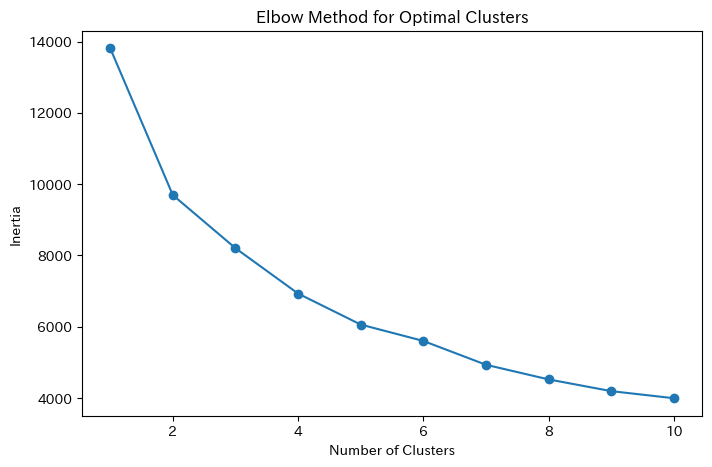

In [27]:
# KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# クラスタ数の候補
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# エルボー法のプロット
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

2！！

In [28]:
# 適切なクラスタ数を選択（例: 3）
optimal_clusters = 2

# K-Meansクラスタリングの実行
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
specific_df["Cluster"] = kmeans.fit_predict(scaled_data)


In [29]:
# 各クラスタの平均値を計算
cluster_summary = specific_df.groupby("Cluster")[features].mean()
print(cluster_summary)

            売上変化率          移動平均          累積売上
Cluster                                      
0        0.093321  26689.464460  4.457353e+07
1       -0.103445  24934.267334  4.539729e+07


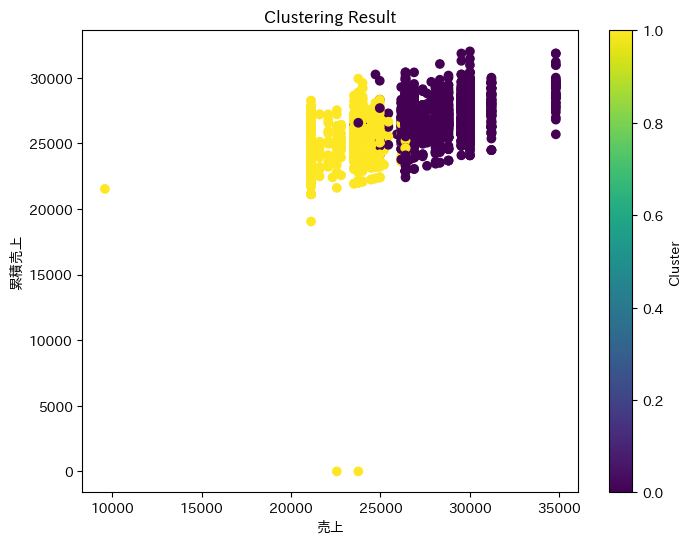

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(specific_df["売上"], specific_df["移動平均"], c=specific_df["Cluster"], cmap="viridis")
plt.xlabel("売上")
plt.ylabel("累積売上")
plt.title("Clustering Result")
plt.colorbar(label="Cluster")
plt.show()

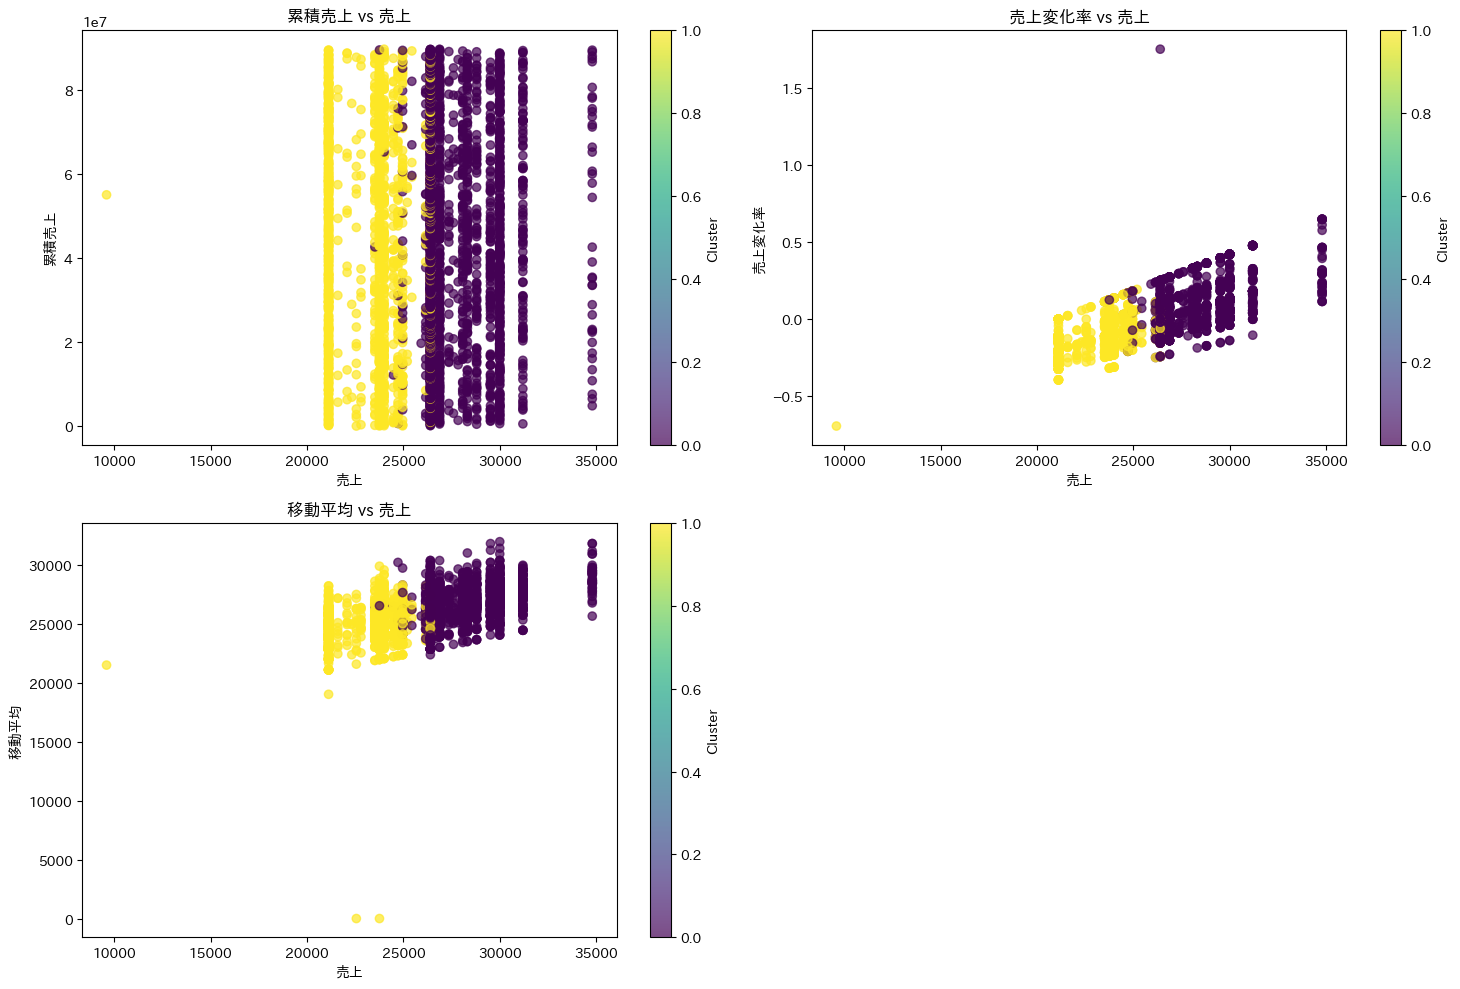

In [31]:
import matplotlib.pyplot as plt

# 散布図に使用するペアの指定
pairs = [("累積売上", "売上"), ("売上変化率", "売上"), ("移動平均", "売上")]

# 図のサイズ
plt.figure(figsize=(15, 10))

# for文で各ペアをプロット
for i, (y_col, x_col) in enumerate(pairs, start=1):
    plt.subplot(2, 2, i)  # サブプロット設定
    plt.scatter(specific_df[x_col], specific_df[y_col], c=specific_df["Cluster"], cmap="viridis", alpha=0.7)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")
    plt.colorbar(label="Cluster")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

# グラフを表示
plt.tight_layout()
plt.show()


これどうやって見る年！！！

GPTに見せた結果

**累積売上 vs 売上**

縦軸（累積売上）と横軸（売上）:売上が高い週ほど累積売上が大きくなるのは予想される傾向です。

紫色クラスタ（クラスタ0）:
中程度から高い売上が多く、累積売上も一定以上に達している。
安定した高売上を持つグループ。

黄色クラスタ（クラスタ1）:
売上がやや低めで累積売上もそれほど伸びていない。
特定の条件（季節や商品）に影響されている可能性があります。

**売上変化率 vs 売上**

縦軸（売上変化率）と横軸（売上）:
売上が小さい週ほど変化率が大きくなる傾向が見えます。

黄色クラスタ（クラスタ1）:
売上変化率が非常に高い（1.0以上）ポイントがあり、売上が急激に変化している週がある。
このクラスタは変動が激しい期間を表す可能性があります。

紫色クラスタ（クラスタ0）:
売上が高いほど変化率が小さく安定している。
安定した売上を持つ週のグループ。

**移動平均 vs 売上**

縦軸（移動平均）と横軸（売上）:
移動平均が売上に近い値を取る週が多いですが、一部例外があります。

黄色クラスタ（クラスタ1）:
売上がやや低めで移動平均がばらついている。特に低売上時に移動平均値が極端に低いケースが目立つ。
売上が不安定で、直近の平均売上に影響を与えている可能性があります。

紫色クラスタ（クラスタ0）:
売上と移動平均がほぼ一致しており、売上の変動が少ない。

**全体的な傾向**

クラスタ間の違い:

クラスタ0（紫）:
高売上で安定している週が多い。
累積売上や移動平均も安定している。

クラスタ1（黄）:
売上がやや低めで、変動が激しい週が多い。
短期間での売上変化が特徴的。

外れ値の観察:
売上変化率で大きく突出している週（特に黄色クラスタ）が観察される。
特定の条件で売上が急増または急減している可能性があります。

用途ごとの考察:
安定した週（クラスタ0）は通常の運用や予測に適している。
変動の激しい週（クラスタ1）は、特定のイベントやキャンペーンが影響しているかもしれません。



次のアクション

クラスタの詳細分析:
黄色クラスタ（クラスタ1）に含まれる週が何に影響を受けているのかを確認（例えば季節や特定商品の影響）。

特異点の分析:
売上変化率が極端な週に着目し、要因を調査。

マーケティング戦略の立案:
安定したクラスタ（クラスタ0）に対して通常の施策を実施。
変動が激しいクラスタ（クラスタ1）に対して、特別な対策を講じる。


## Dynamic Time Warping

In [32]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.2 MB/s eta 0:00:00


In [33]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3453 entries, 21263 to 24715
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   伝票日付     3453 non-null   datetime64[ns]
 1   商品コード    3453 non-null   int64         
 2   商品名      3453 non-null   object        
 3   入数       3453 non-null   int64         
 4   単価       3453 non-null   int64         
 5   週        3453 non-null   datetime64[ns]
 6   売上       3453 non-null   int64         
 7   週番号      3453 non-null   UInt32        
 8   月        3453 non-null   int32         
 9   曜日       3453 non-null   int32         
 10  売上変化率    3453 non-null   float64       
 11  移動平均     3453 non-null   float64       
 12  累積売上     3453 non-null   int64         
 13  季節_冬     3453 non-null   bool          
 14  季節_夏     3453 non-null   bool          
 15  季節_春     3453 non-null   bool          
 16  季節_秋     3453 non-null   bool          
 17  Cluster  3453 non-null   int32   

In [34]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [35]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [36]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])


<ipython-input-37-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


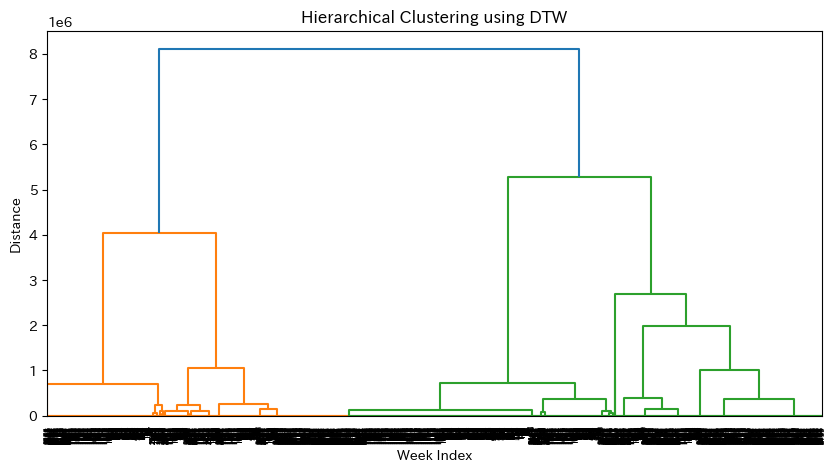

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [38]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [39]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.6276400353054977


          count          mean          std      min      25%      50%  \
cluster                                                                 
1        1343.0  22982.457185  1464.131582  21120.0  21120.0  23760.0   
2        1186.0  26551.973019   302.411661  25920.0  26400.0  26400.0   
3         924.0  29648.311688  1571.461688   9600.0  28320.0  29520.0   

             75%      max  
cluster                    
1        24000.0  25440.0  
2        26880.0  27840.0  
3        30000.0  34800.0  


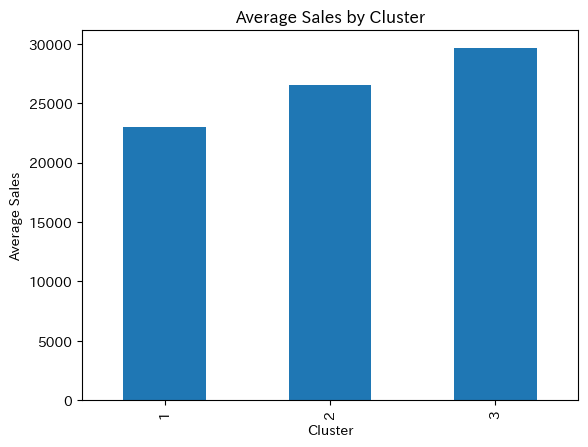

In [40]:
# クラスタごとの統計情報
print(specific_df_sorted.groupby('cluster')['売上'].describe())

# クラスタごとの平均売上をプロット
specific_df_sorted.groupby('cluster')['売上'].mean().plot(kind='bar', title='Average Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.show()

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# クラスタ1のデータに絞る
cluster1_sales = specific_df_sorted[specific_df_sorted['cluster'] == 1]['売上']

# ARIMAモデルの作成
model = ARIMA(cluster1_sales, order=(1, 1, 1))
model_fit = model.fit()

# 予測
forecast = model_fit.forecast(steps=5)
print(f"Next 5 weeks forecast: {forecast}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Next 5 weeks forecast: 1343    23764.893184
1344    23765.014545
1345    23765.017555
1346    23765.017630
1347    23765.017632
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3453 entries, 21263 to 24715
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   伝票日付     3453 non-null   datetime64[ns]
 1   商品コード    3453 non-null   int64         
 2   商品名      3453 non-null   object        
 3   入数       3453 non-null   int64         
 4   単価       3453 non-null   int64         
 5   週        3453 non-null   datetime64[ns]
 6   売上       3453 non-null   int64         
 7   週番号      3453 non-null   UInt32        
 8   月        3453 non-null   int32         
 9   曜日       3453 non-null   int32         
 10  売上変化率    3453 non-null   float64       
 11  移動平均     3453 non-null   float64       
 12  累積売上     3453 non-null   int64         
 13  季節_冬     3453 non-null   bool          
 14  季節_夏     3453 non-null   bool          
 15  季節_春     3453 non-null   bool          
 16  季節_秋     3453 non-null   bool          
 17  Cluster  3453 non-null   int32   

In [43]:
# '週' 列をインデックスとして設定
specific_df_sorted.set_index('週', inplace=True)

# 再確認
print(specific_df_sorted.index)

DatetimeIndex(['2020-11-02', '2020-11-02', '2020-11-02', '2020-11-02',
               '2020-11-02', '2020-11-02', '2020-11-02', '2020-11-02',
               '2020-11-02', '2020-11-02',
               ...
               '2024-09-23', '2024-09-23', '2024-09-23', '2024-09-23',
               '2024-09-23', '2024-09-23', '2024-09-23', '2024-09-30',
               '2024-09-30', '2024-09-30'],
              dtype='datetime64[ns]', name='週', length=3453, freq=None)


# シュミテクト　歯周病ケア　９０ｇ

In [44]:
# 辞書の中から1つだけ取り出す。
key = 'シュミテクト　歯周病ケア　９０ｇ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

            伝票日付   商品コード               商品名  入数   単価          週     売上  週番号  \
12003 2024-01-16  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2024-01-15  32184    3   
12004 2023-10-03  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2023-10-02  32184   40   
12005 2023-03-22  220278  シュミテクト　歯周病ケア　９０ｇ  72  500 2023-03-20  36000   12   
12006 2022-01-18  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2022-01-17  32184    3   
12007 2024-01-16  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2024-01-15  32184    3   
...          ...     ...               ...  ..  ...        ...    ...  ...   
14110 2021-07-05  220278  シュミテクト　歯周病ケア　９０ｇ  72  500 2021-07-05  36000   27   
14111 2022-12-06  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2022-12-05  32184   49   
14112 2021-06-11  220278  シュミテクト　歯周病ケア　９０ｇ  72  500 2021-06-07  36000   23   
14113 2023-04-04  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2023-04-03  32184   14   
14114 2021-04-30  220278  シュミテクト　歯周病ケア　９０ｇ  72  447 2021-04-26  32184   17   

        月  曜日 季節     売上変化率     移動平均      累積売上  
12003   1   0  

In [45]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2112 entries, 12003 to 14114
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   伝票日付    2112 non-null   datetime64[ns]
 1   商品コード   2112 non-null   int64         
 2   商品名     2112 non-null   object        
 3   入数      2112 non-null   int64         
 4   単価      2112 non-null   int64         
 5   週       2112 non-null   datetime64[ns]
 6   売上      2112 non-null   int64         
 7   週番号     2112 non-null   UInt32        
 8   月       2112 non-null   int32         
 9   曜日      2112 non-null   int32         
 10  季節      2112 non-null   object        
 11  売上変化率   2112 non-null   float64       
 12  移動平均    2112 non-null   float64       
 13  累積売上    2112 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int32(2), int64(5), object(2)
memory usage: 224.8+ KB


## 標準化

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [47]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

### k-means

季節を組み込むクラスタリング

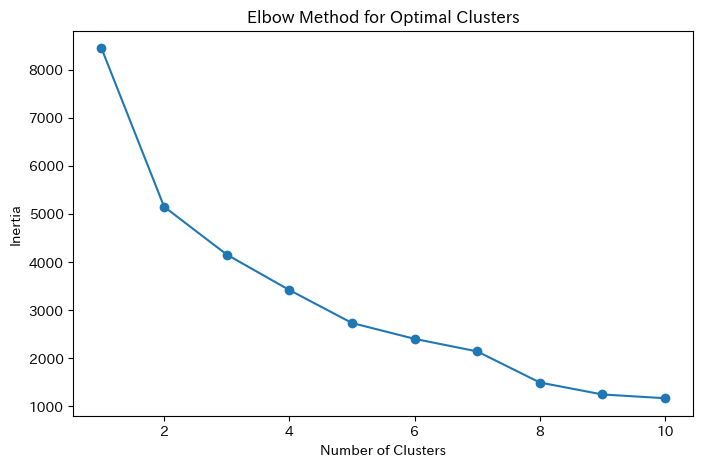

In [48]:
# KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# クラスタ数の候補
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# エルボー法のプロット
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

2!!!

#### 標準化

In [49]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2112 entries, 12003 to 14114
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   伝票日付    2112 non-null   datetime64[ns]
 1   商品コード   2112 non-null   int64         
 2   商品名     2112 non-null   object        
 3   入数      2112 non-null   int64         
 4   単価      2112 non-null   int64         
 5   週       2112 non-null   datetime64[ns]
 6   売上      2112 non-null   int64         
 7   週番号     2112 non-null   UInt32        
 8   月       2112 non-null   int32         
 9   曜日      2112 non-null   int32         
 10  売上変化率   2112 non-null   float64       
 11  移動平均    2112 non-null   float64       
 12  累積売上    2112 non-null   int64         
 13  季節_冬    2112 non-null   bool          
 14  季節_夏    2112 non-null   bool          
 15  季節_春    2112 non-null   bool          
 16  季節_秋    2112 non-null   bool          
dtypes: UInt32(1), bool(4), datetime64[ns](2), float64(2)

In [50]:
specific_df_encoded = pd.get_dummies(specific_df, columns=['季節_冬', '季節_春', '季節_夏', '季節_秋'])
specific_df_encoded.head()

,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,...,移動平均,累積売上,季節_冬_False,季節_冬_True,季節_春_False,季節_春_True,季節_夏_False,季節_夏_True,季節_秋_False,季節_秋_True
12003,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,...,0.0,32184,False,True,True,False,True,False,True,False
12004,2023-10-03,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-10-02,32184,40,10,0,...,0.0,64368,True,False,True,False,True,False,False,True
12005,2023-03-22,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2023-03-20,36000,12,3,0,...,33456.0,100368,True,False,False,True,True,False,True,False
12006,2022-01-18,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-01-17,32184,3,1,0,...,33456.0,132552,False,True,True,False,True,False,True,False
12007,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,...,33456.0,164736,False,True,True,False,True,False,True,False


In [51]:
# ブール型の列を数値に変換（True=1, False=0）
specific_df_encoded = specific_df.copy()

# 例: 季節の列がTrue/Falseの場合、get_dummiesを使わず直接変換
specific_df_encoded['季節_春'] = specific_df_encoded['季節_春'].astype(int)
specific_df_encoded['季節_夏'] = specific_df_encoded['季節_夏'].astype(int)
specific_df_encoded['季節_秋'] = specific_df_encoded['季節_秋'].astype(int)
specific_df_encoded['季節_冬'] = specific_df_encoded['季節_冬'].astype(int)

# 変換後のデータを表示
specific_df_encoded.head()


,伝票日付,商品コード,商品名,入数,単価,週,売上,週番号,月,曜日,売上変化率,移動平均,累積売上,季節_冬,季節_夏,季節_春,季節_秋
12003,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,0.000000,0.0,32184,1,0,0,0
12004,2023-10-03,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2023-10-02,32184,40,10,0,0.000000,0.0,64368,0,0,0,1
12005,2023-03-22,220278,シュミテクト 歯周病ケア ９０ｇ,72,500,2023-03-20,36000,12,3,0,0.118568,33456.0,100368,0,0,1,0
12006,2022-01-18,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2022-01-17,32184,3,1,0,-0.106000,33456.0,132552,1,0,0,0
12007,2024-01-16,220278,シュミテクト 歯周病ケア ９０ｇ,72,447,2024-01-15,32184,3,1,0,0.000000,33456.0,164736,1,0,0,0


In [52]:
# 使用するカラムを選択
features = specific_df_encoded[['移動平均', '累積売上', '売上変化率', '季節_春', '季節_夏', '季節_秋', '季節_冬']]

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

#### クラスタリング

In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
specific_df_encoded["Cluster"] = kmeans.fit_predict(scaled_data)


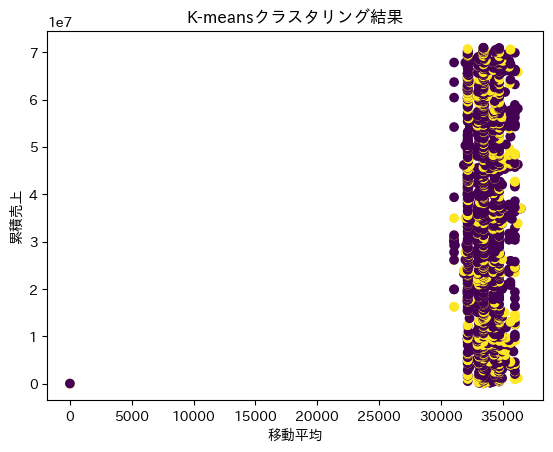

In [55]:
import matplotlib.pyplot as plt

# クラスタリング結果を可視化
plt.scatter(specific_df_encoded['移動平均'], specific_df_encoded['累積売上'], c=specific_df_encoded['Cluster'], cmap='viridis')
plt.xlabel('移動平均')
plt.ylabel('累積売上')
plt.title('K-meansクラスタリング結果')
plt.show()

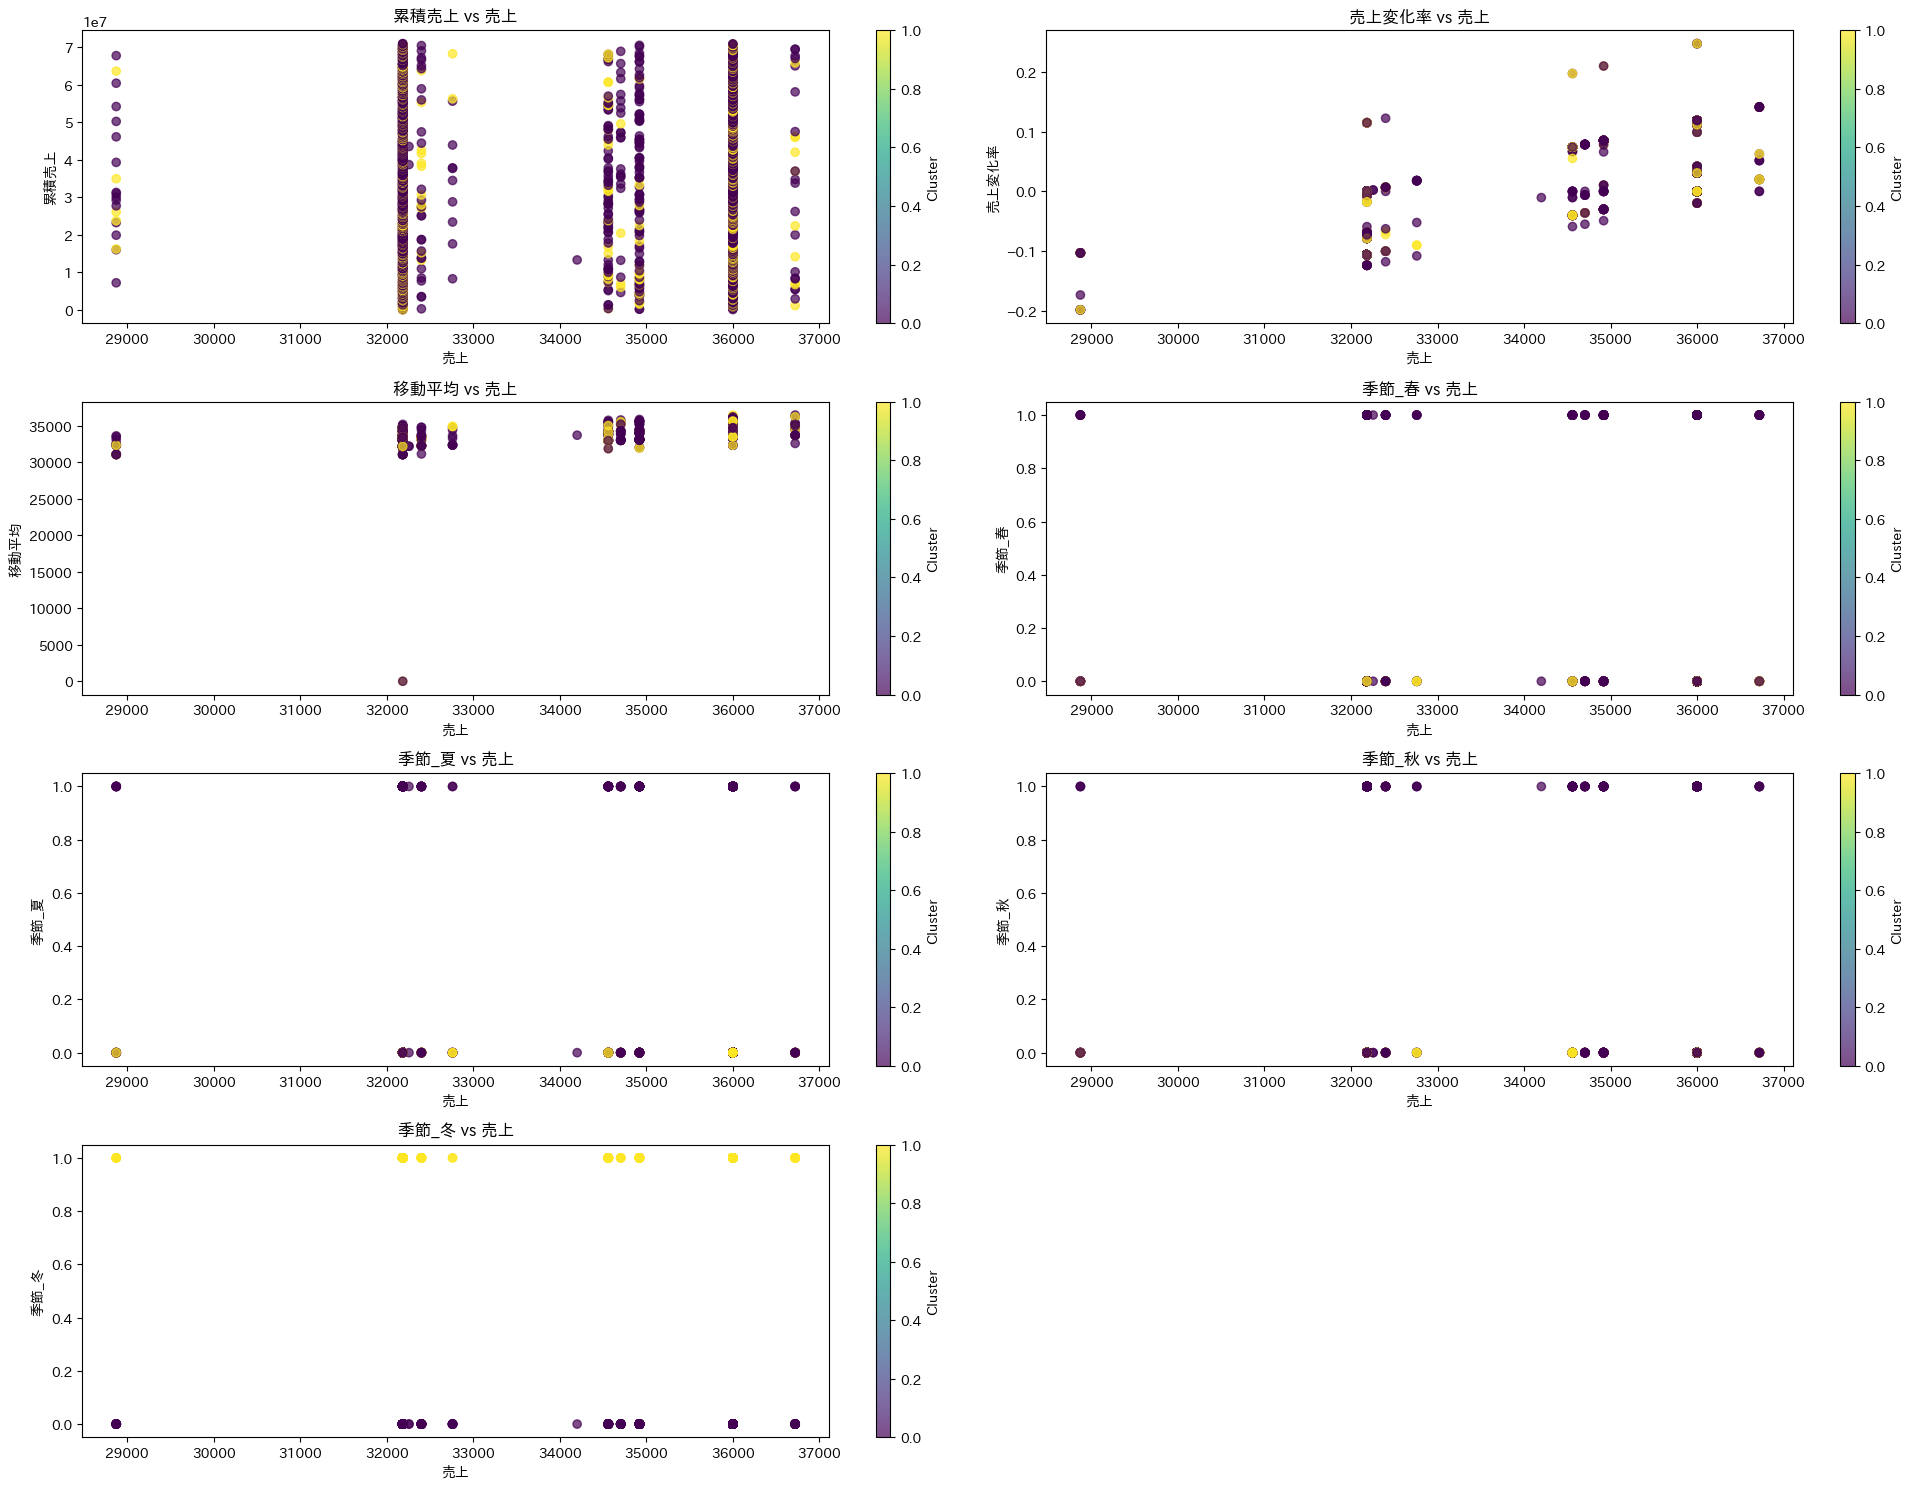

In [56]:
# 散布図に使用するペアの指定
pairs = [("累積売上", "売上"), ("売上変化率", "売上"), ("移動平均", "売上"),('季節_春', "売上"), ('季節_夏','売上'),('季節_秋','売上'),('季節_冬',"売上")]

# 図のサイズ
plt.figure(figsize=(20, 15))

# for文で各ペアをプロット
for i, (y_col, x_col) in enumerate(pairs, start=1):
    plt.subplot(4, 2, i)  # サブプロット設定
    plt.scatter(specific_df[x_col], specific_df[y_col], c=specific_df_encoded["Cluster"], cmap="viridis", alpha=0.7)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")
    plt.colorbar(label="Cluster")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

# グラフを表示
plt.tight_layout()
plt.show()


In [57]:
# from sklearn.metrics import silhouette_score

# # シルエットスコアの計算
# silhouette_avg = silhouette_score(specific_df, kmeans.labels_)
# print(f"Silhouette Score: {silhouette_avg}")

# 数値列のみを抽出
numeric_columns = specific_df.select_dtypes(include=['float64', 'int64']).columns
numeric_data = specific_df[numeric_columns]

# シルエットスコアの計算
silhouette_avg = silhouette_score(numeric_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.036798249451130756


シルエットスコアは低いです。

シルエットスコアは、クラスタリングがどれだけ分離されているか、またクラスタ内でどれだけ凝集しているかを示す指標です。

スコアの範囲:

1に近い: クラスタリングが良好で、各クラスタが明確に分離されている。

0付近: クラスタ間の分離が曖昧で、クラスタの構造が不明瞭。

負の値: データが正しいクラスタに割り当てられていない可能性が高い。

改善方法
1. クラスタ数を調整
クラスタ数を増減させてシルエットスコアを再計算します。
エルボー法やシルエット分析を用いて適切なクラスタ数を見つけます。

2.特徴量の見直し
3.データのスケールを統一

季節が上下に離れているのは、ダミー変数として数値化されているから。

. 季節ごとの販売パターンの把握

例えば、「季節_春 vs 売上」や「季節_夏 vs 売上」の散布図を見ると、季節による売上の傾向が一部のクラスタに強く関連していることが見て取れます。特に売上が高い、または低いクラスタが季節ごとに分かれている場合、季節が売上に与える影響が強いことが示唆されています。
これにより、売上の季節変動に対応した戦略を立てるための情報が得られます。

3. 季節と売上変化率、移動平均の相関

他のプロット（「移動平均 vs 売上」、「売上変化率 vs 売上」など）でも、季節性の影響が色分けされているため、季節ごとの売上の変動がどのように移動平均や売上変化率に影響しているかを見ることができます。
たとえば、特定の季節に売上変化率が高いクラスタがある場合、その季節における売上の急増や急減を反映していることが確認できるでしょう。

4. 季節ごとの異常値やパターンの発見

もし、特定の季節に異常に売上が低かったり高かったりするクラスタがある場合、それがどの季節に関係しているのかを確認することができます。季節性を反映することで、異常なパターンや売上の急激な変動をより明確に把握できる可能性があります。

冨樫先生が言ってたやつはDTWか

### DTW

In [58]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [59]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [60]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])


### できなかった

In [61]:
# 型式確認
print(distance_matrix.shape)
print((distance_matrix == distance_matrix.T).all())  # True なら対称

(2112, 2112)
True


(n,n)の場合は、圧縮する必要がある

In [62]:
from scipy.spatial.distance import squareform

# 距離行列を圧縮形式に変換
compressed_distance_matrix = squareform(distance_matrix)

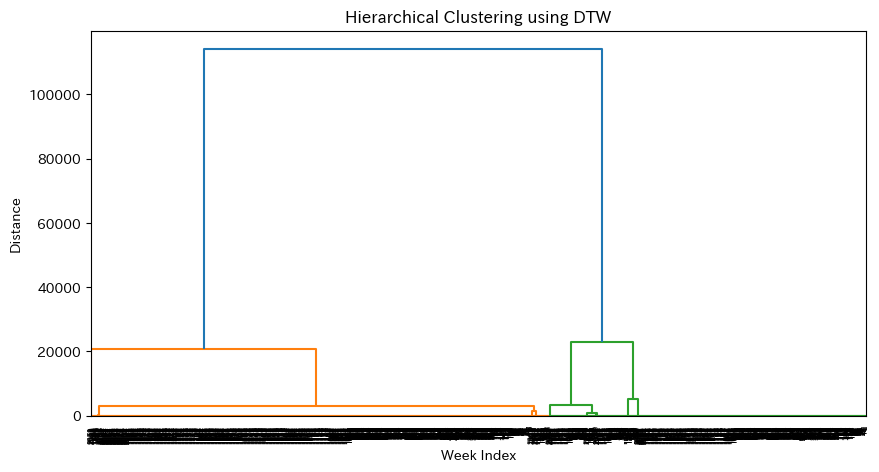

In [63]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(3000)  # 再帰深度を増加


# 圧縮形式の距離行列を使用してリンク生成
linkage_matrix = linkage(compressed_distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")
plt.show()

再帰深度を3000にしたらできた。

In [64]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# # 階層的クラスタリング
# linkage_matrix = linkage(distance_matrix, method='ward')

# # デンドログラムの描画
# plt.figure(figsize=(10, 5))
# dendrogram(linkage_matrix)
# plt.title("Hierarchical Clustering using DTW")
# plt.xlabel("Week Index")
# plt.ylabel("Distance")

#   # ファイルに保存
# # plt.tight_layout()
# # plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# # plt.close()
# # print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

# plt.show()

In [65]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

In [66]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.9506104890203644


(クラスタ数)-1×4行の行列が正解

# ジッポライタ―オイル　１３３ＭＬ

In [67]:
# 辞書の中から1つだけ取り出す。
key = 'ジッポライタ―オイル　１３３ＭＬ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

            伝票日付    商品コード               商品名  入数   単価          週     売上  週番号  \
15546 2024-04-12  4010001  ジッポライタ―オイル　１３３ＭＬ  96  462 2024-04-08  44352   15   
15547 2024-03-15  4010001  ジッポライタ―オイル　１３３ＭＬ  96  462 2024-03-11  44352   11   
15548 2024-06-10  4010001  ジッポライタ―オイル　１３３ＭＬ  96  450 2024-06-10  43200   24   
15549 2024-01-29  4010001  ジッポライタ―オイル　１３３ＭＬ  96  462 2024-01-29  44352    5   
15550 2024-09-23  4010001  ジッポライタ―オイル　１３３ＭＬ  96  450 2024-09-23  43200   39   
...          ...      ...               ...  ..  ...        ...    ...  ...   
18989 2022-07-01  4010001  ジッポライタ―オイル　１３３ＭＬ  24  250 2022-06-27   6000   26   
18990 2024-02-12  4010001  ジッポライタ―オイル　１３３ＭＬ  96  462 2024-02-12  44352    7   
18991 2024-05-20  4010001  ジッポライタ―オイル　１３３ＭＬ  96  450 2024-05-20  43200   21   
18992 2022-04-04  4010001  ジッポライタ―オイル　１３３ＭＬ  24  250 2022-04-04   6000   14   
18993 2023-04-10  4010001  ジッポライタ―オイル　１３３ＭＬ  24  462 2023-04-10  11088   15   

       月  曜日 季節     売上変化率     移動平均      累積売上  
1554

## 標準化

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [69]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [70]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [71]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [72]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-73-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


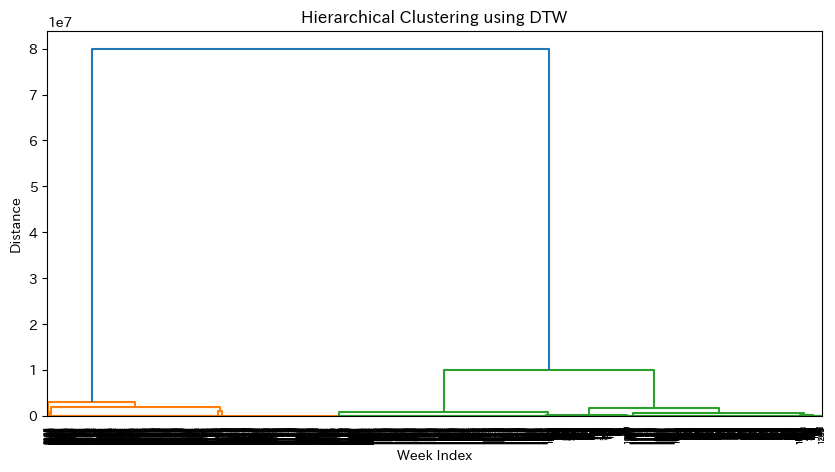

In [73]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [74]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [75]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.9444210895341191


# ホ―ケン　いきいき奥さん　３Ｐ

In [76]:
# 辞書の中から1つだけ取り出す。
key = 'ホ―ケン　いきいき奥さん　３Ｐ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード              商品名   入数   単価          週     売上  週番号  \
4885 2021-01-26  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2021-01-25  36000    4   
4886 2020-11-03  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2020-11-02  36000   45   
4887 2022-07-05  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2022-07-04  36000   27   
4888 2021-10-19  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2021-10-18  36000   42   
4889 2023-01-10  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2023-01-09  36000    2   
...         ...      ...              ...  ...  ...        ...    ...  ...   
6585 2022-06-21  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2022-06-20  36000   25   
6586 2024-07-23  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2024-07-22  36000   30   
6587 2022-02-15  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2022-02-14  36000    7   
6588 2022-12-20  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2022-12-19  36000   51   
6589 2024-07-23  4060029  ホ―ケン　いきいき奥さん　３Ｐ  100  360 2024-07-22  36000   30   

       月  曜日 季節  売上変化率     移動平均      累積売上  
4885   1   0  冬    

In [77]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1705 entries, 4885 to 6589
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   伝票日付    1705 non-null   datetime64[ns]
 1   商品コード   1705 non-null   int64         
 2   商品名     1705 non-null   object        
 3   入数      1705 non-null   int64         
 4   単価      1705 non-null   int64         
 5   週       1705 non-null   datetime64[ns]
 6   売上      1705 non-null   int64         
 7   週番号     1705 non-null   UInt32        
 8   月       1705 non-null   int32         
 9   曜日      1705 non-null   int32         
 10  季節      1705 non-null   object        
 11  売上変化率   1705 non-null   float64       
 12  移動平均    1705 non-null   float64       
 13  累積売上    1705 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int32(2), int64(5), object(2)
memory usage: 181.5+ KB


## 標準化

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [79]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [80]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [81]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [82]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-83-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


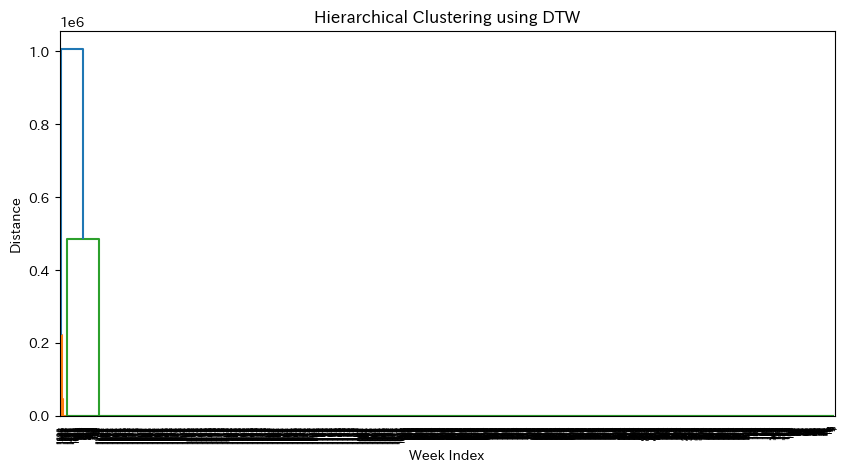

In [83]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [84]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [85]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.9904180970406316


# 毎日香　黄箱　小型　バラ詰

In [86]:
# 辞書の中から1つだけ取り出す。
key = '毎日香　黄箱　小型　バラ詰'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

            伝票日付    商品コード            商品名   入数   単価          週     売上  週番号   月  \
9705  2024-06-27  1520132  毎日香　黄箱　小型　バラ詰  100  294 2024-06-24  29400   26   6   
9706  2021-11-05  1520132  毎日香　黄箱　小型　バラ詰  100  266 2021-11-01  26600   44  11   
9707  2023-07-20  1520132  毎日香　黄箱　小型　バラ詰  100  330 2023-07-17  33000   29   7   
9708  2022-09-16  1520132  毎日香　黄箱　小型　バラ詰  100  266 2022-09-12  26600   37   9   
9709  2023-07-24  1520132  毎日香　黄箱　小型　バラ詰  100  294 2023-07-24  29400   30   7   
...          ...      ...            ...  ...  ...        ...    ...  ...  ..   
11998 2022-06-06  1520132  毎日香　黄箱　小型　バラ詰  100  266 2022-06-06  26600   23   6   
11999 2023-08-03  1520132  毎日香　黄箱　小型　バラ詰  100  327 2023-07-31  32700   31   7   
12000 2024-09-06  1520132  毎日香　黄箱　小型　バラ詰  100  294 2024-09-02  29400   36   9   
12001 2021-09-24  1520132  毎日香　黄箱　小型　バラ詰  100  266 2021-09-20  26600   38   9   
12002 2022-05-02  1520132  毎日香　黄箱　小型　バラ詰  100  260 2022-05-02  26000   18   5   

       曜日 季節     売上変化率     

## 標準化

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [88]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [89]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [90]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [91]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-92-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


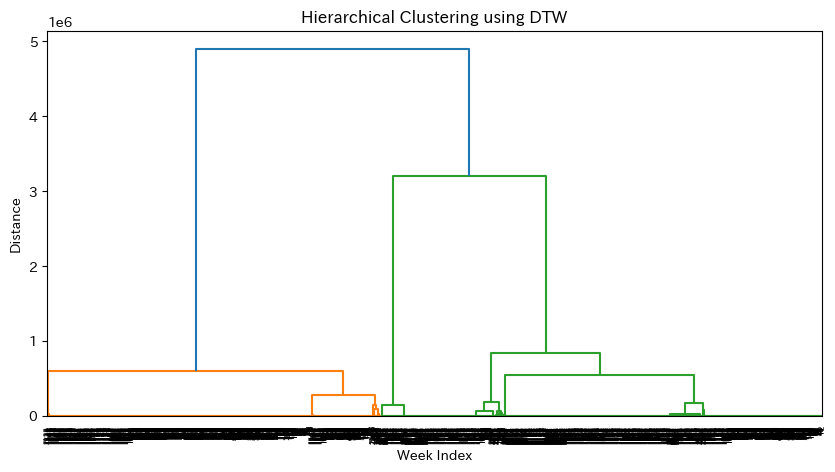

In [92]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [93]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [94]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.8774944469092275


# 虎マッチ　並型　１２Ｐ

In [98]:
# 辞書の中から1つだけ取り出す。
key = '虎マッチ　並型　１２Ｐ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード          商品名   入数   単価          週     売上  週番号   月  \
839  2021-06-10  1560022  虎マッチ　並型　１２Ｐ  100  150 2021-06-07  15000   23   6   
840  2023-02-02  1560022  虎マッチ　並型　１２Ｐ  100  150 2023-01-30  15000    5   1   
841  2021-06-22  1560022  虎マッチ　並型　１２Ｐ  100  128 2021-06-21  12800   25   6   
842  2020-12-07  1560022  虎マッチ　並型　１２Ｐ  100  142 2020-12-07  14200   50  12   
843  2023-10-09  1560022  虎マッチ　並型　１２Ｐ  100  165 2023-10-09  16500   41  10   
...         ...      ...          ...  ...  ...        ...    ...  ...  ..   
4880 2023-01-19  1560022  虎マッチ　並型　１２Ｐ  100  140 2023-01-16  14000    3   1   
4881 2022-06-30  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-06-27  15000   26   6   
4882 2021-09-09  1560022  虎マッチ　並型　１２Ｐ  100  142 2021-09-06  14200   36   9   
4883 2022-02-28  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-02-28  15000    9   2   
4884 2021-02-11  1560022  虎マッチ　並型　１２Ｐ  100  130 2021-02-08  13000    6   2   

      曜日 季節     売上変化率          移動平均      累積売上  
839    0  夏  0.

## 標準化

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [100]:
specific_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4046 entries, 839 to 4884
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   伝票日付    4046 non-null   datetime64[ns]
 1   商品コード   4046 non-null   int64         
 2   商品名     4046 non-null   object        
 3   入数      4046 non-null   int64         
 4   単価      4046 non-null   int64         
 5   週       4046 non-null   datetime64[ns]
 6   売上      4046 non-null   int64         
 7   週番号     4046 non-null   UInt32        
 8   月       4046 non-null   int32         
 9   曜日      4046 non-null   int32         
 10  季節      4046 non-null   object        
 11  売上変化率   4046 non-null   float64       
 12  移動平均    4046 non-null   float64       
 13  累積売上    4046 non-null   int64         
dtypes: UInt32(1), datetime64[ns](2), float64(2), int32(2), int64(5), object(2)
memory usage: 430.7+ KB


In [101]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [102]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [103]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [104]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-105-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


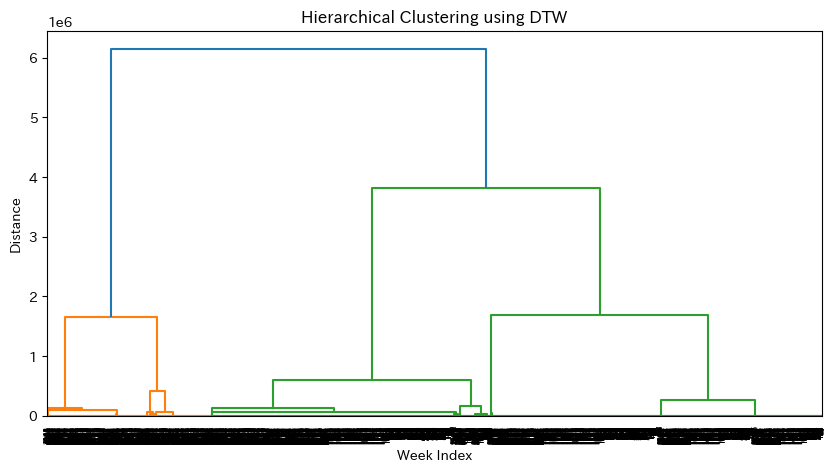

In [105]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [106]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [107]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.7675883763190617


# 青雲バイオレット　バラ詰１２５ｇ

In [110]:
# 辞書の中から1つだけ取り出す。
key = '青雲バイオレット　バラ詰１２５ｇ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

            伝票日付    商品コード               商品名  入数   単価          週     売上  週番号  \
18994 2022-08-04  1520137  青雲バイオレット　バラ詰１２５ｇ  60  585 2022-08-01  35100   31   
18995 2022-11-14  1520137  青雲バイオレット　バラ詰１２５ｇ  60  585 2022-11-14  35100   46   
18996 2023-07-17  1520137  青雲バイオレット　バラ詰１２５ｇ  60  743 2023-07-17  44580   29   
18997 2023-01-19  1520137  青雲バイオレット　バラ詰１２５ｇ  60  585 2023-01-16  35100    3   
18998 2024-09-16  1520137  青雲バイオレット　バラ詰１２５ｇ  60  660 2024-09-16  39600   38   
...          ...      ...               ...  ..  ...        ...    ...  ...   
21258 2024-08-19  1520137  青雲バイオレット　バラ詰１２５ｇ  60  660 2024-08-19  39600   34   
21259 2022-03-18  1520137  青雲バイオレット　バラ詰１２５ｇ  60  586 2022-03-14  35160   11   
21260 2023-01-12  1520137  青雲バイオレット　バラ詰１２５ｇ  60  675 2023-01-09  40500    2   
21261 2023-08-07  1520137  青雲バイオレット　バラ詰１２５ｇ  60  660 2023-08-07  39600   32   
21262 2022-12-02  1520137  青雲バイオレット　バラ詰１２５ｇ  60  660 2022-11-28  39600   48   

        月  曜日 季節     売上変化率     移動平均      累積売上  
189

## 標準化

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [112]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [113]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [114]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [115]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-116-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


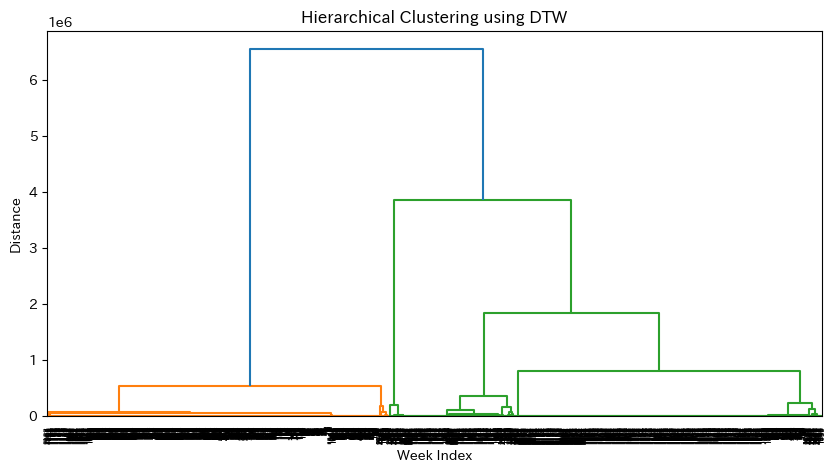

In [116]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [117]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [118]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.8507458099940605


# 香樹林　大線香　バラ

In [119]:
# 辞書の中から1つだけ取り出す。
key = '香樹林　大線香　バラ'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード          商品名   入数   単価          週     売上  週番号   月  \
839  2021-06-10  1560022  虎マッチ　並型　１２Ｐ  100  150 2021-06-07  15000   23   6   
840  2023-02-02  1560022  虎マッチ　並型　１２Ｐ  100  150 2023-01-30  15000    5   1   
841  2021-06-22  1560022  虎マッチ　並型　１２Ｐ  100  128 2021-06-21  12800   25   6   
842  2020-12-07  1560022  虎マッチ　並型　１２Ｐ  100  142 2020-12-07  14200   50  12   
843  2023-10-09  1560022  虎マッチ　並型　１２Ｐ  100  165 2023-10-09  16500   41  10   
...         ...      ...          ...  ...  ...        ...    ...  ...  ..   
4880 2023-01-19  1560022  虎マッチ　並型　１２Ｐ  100  140 2023-01-16  14000    3   1   
4881 2022-06-30  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-06-27  15000   26   6   
4882 2021-09-09  1560022  虎マッチ　並型　１２Ｐ  100  142 2021-09-06  14200   36   9   
4883 2022-02-28  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-02-28  15000    9   2   
4884 2021-02-11  1560022  虎マッチ　並型　１２Ｐ  100  130 2021-02-08  13000    6   2   

      曜日 季節     売上変化率          移動平均      累積売上  
839    0  夏  0.

## 標準化

In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [121]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [122]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [123]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [124]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-125-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


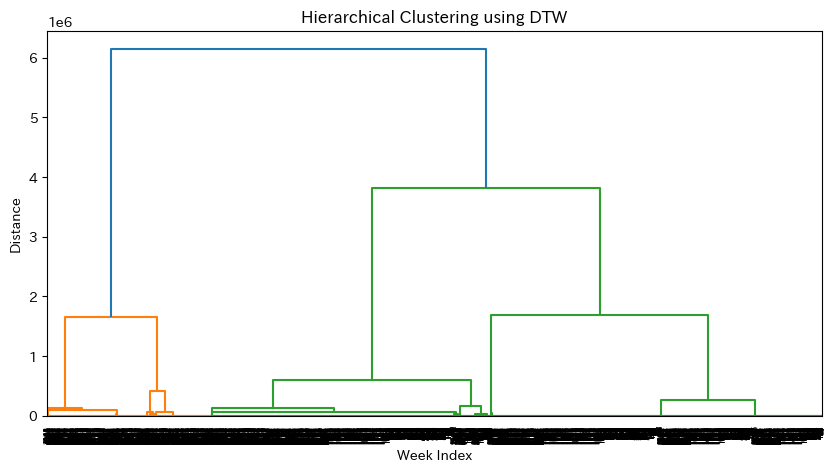

In [125]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [126]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [127]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.7675883763190617


# ＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚

In [128]:
# 辞書の中から1つだけ取り出す。
key = '＊ＲＳ３７Ｌ　ＨＢマスク　普通６枚'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード          商品名   入数   単価          週     売上  週番号   月  \
839  2021-06-10  1560022  虎マッチ　並型　１２Ｐ  100  150 2021-06-07  15000   23   6   
840  2023-02-02  1560022  虎マッチ　並型　１２Ｐ  100  150 2023-01-30  15000    5   1   
841  2021-06-22  1560022  虎マッチ　並型　１２Ｐ  100  128 2021-06-21  12800   25   6   
842  2020-12-07  1560022  虎マッチ　並型　１２Ｐ  100  142 2020-12-07  14200   50  12   
843  2023-10-09  1560022  虎マッチ　並型　１２Ｐ  100  165 2023-10-09  16500   41  10   
...         ...      ...          ...  ...  ...        ...    ...  ...  ..   
4880 2023-01-19  1560022  虎マッチ　並型　１２Ｐ  100  140 2023-01-16  14000    3   1   
4881 2022-06-30  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-06-27  15000   26   6   
4882 2021-09-09  1560022  虎マッチ　並型　１２Ｐ  100  142 2021-09-06  14200   36   9   
4883 2022-02-28  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-02-28  15000    9   2   
4884 2021-02-11  1560022  虎マッチ　並型　１２Ｐ  100  130 2021-02-08  13000    6   2   

      曜日 季節     売上変化率          移動平均      累積売上  
839    0  夏  0.

## 標準化

In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [130]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [131]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [132]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [133]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-134-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


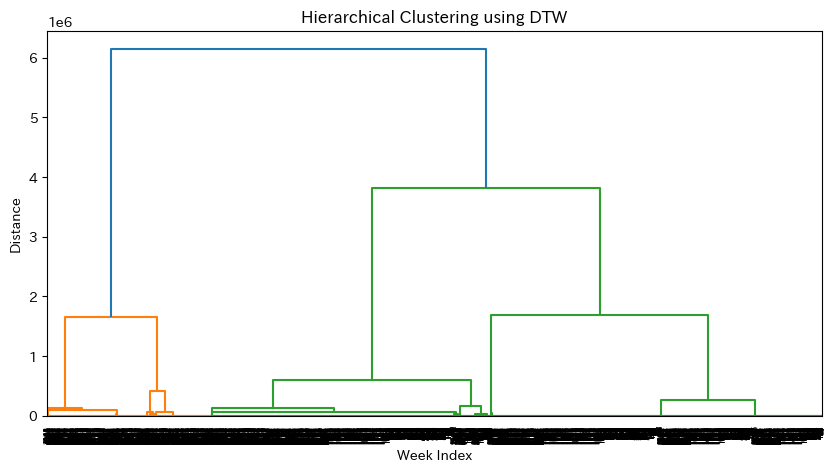

In [134]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [135]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [136]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.7675883763190617


# ＲＳ－１９９　つま楊枝　５００本

In [137]:
# 辞書の中から1つだけ取り出す。
key = 'ＲＳ－１９９　つま楊枝　５００本'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード          商品名   入数   単価          週     売上  週番号   月  \
839  2021-06-10  1560022  虎マッチ　並型　１２Ｐ  100  150 2021-06-07  15000   23   6   
840  2023-02-02  1560022  虎マッチ　並型　１２Ｐ  100  150 2023-01-30  15000    5   1   
841  2021-06-22  1560022  虎マッチ　並型　１２Ｐ  100  128 2021-06-21  12800   25   6   
842  2020-12-07  1560022  虎マッチ　並型　１２Ｐ  100  142 2020-12-07  14200   50  12   
843  2023-10-09  1560022  虎マッチ　並型　１２Ｐ  100  165 2023-10-09  16500   41  10   
...         ...      ...          ...  ...  ...        ...    ...  ...  ..   
4880 2023-01-19  1560022  虎マッチ　並型　１２Ｐ  100  140 2023-01-16  14000    3   1   
4881 2022-06-30  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-06-27  15000   26   6   
4882 2021-09-09  1560022  虎マッチ　並型　１２Ｐ  100  142 2021-09-06  14200   36   9   
4883 2022-02-28  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-02-28  15000    9   2   
4884 2021-02-11  1560022  虎マッチ　並型　１２Ｐ  100  130 2021-02-08  13000    6   2   

      曜日 季節     売上変化率          移動平均      累積売上  
839    0  夏  0.

## 標準化

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [139]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [140]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [141]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [142]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-143-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


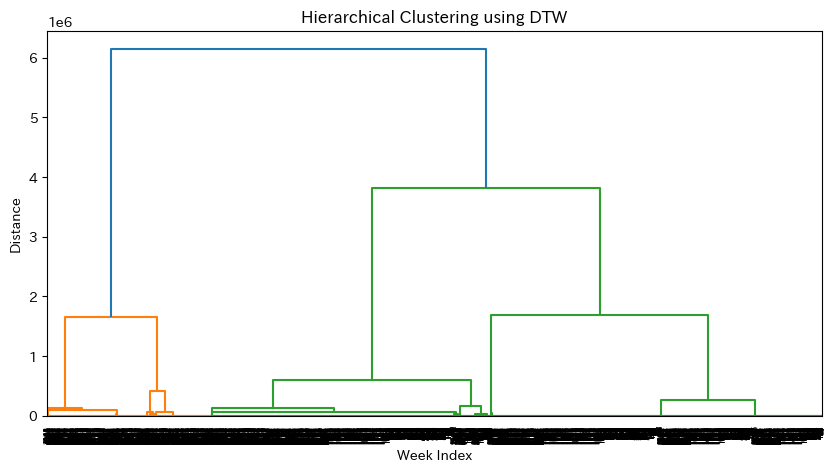

In [143]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [144]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [145]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.7675883763190617


# ＲＳ３７Ｌ　ＨＢマスク　普通６枚

In [146]:
# 辞書の中から1つだけ取り出す。
key = 'ＲＳ３７Ｌ　ＨＢマスク　普通６枚'  # 取り出したい商品のキー
if key in dfs:
    specific_df = dfs[key]
    print(specific_df)
else:
    print(f"キー '{key}' は辞書に存在しません。")

           伝票日付    商品コード          商品名   入数   単価          週     売上  週番号   月  \
839  2021-06-10  1560022  虎マッチ　並型　１２Ｐ  100  150 2021-06-07  15000   23   6   
840  2023-02-02  1560022  虎マッチ　並型　１２Ｐ  100  150 2023-01-30  15000    5   1   
841  2021-06-22  1560022  虎マッチ　並型　１２Ｐ  100  128 2021-06-21  12800   25   6   
842  2020-12-07  1560022  虎マッチ　並型　１２Ｐ  100  142 2020-12-07  14200   50  12   
843  2023-10-09  1560022  虎マッチ　並型　１２Ｐ  100  165 2023-10-09  16500   41  10   
...         ...      ...          ...  ...  ...        ...    ...  ...  ..   
4880 2023-01-19  1560022  虎マッチ　並型　１２Ｐ  100  140 2023-01-16  14000    3   1   
4881 2022-06-30  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-06-27  15000   26   6   
4882 2021-09-09  1560022  虎マッチ　並型　１２Ｐ  100  142 2021-09-06  14200   36   9   
4883 2022-02-28  1560022  虎マッチ　並型　１２Ｐ  100  150 2022-02-28  15000    9   2   
4884 2021-02-11  1560022  虎マッチ　並型　１２Ｐ  100  130 2021-02-08  13000    6   2   

      曜日 季節     売上変化率          移動平均      累積売上  
839    0  夏  0.

## 標準化

In [147]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(specific_df[["売上", "売上変化率", "移動平均", "累積売上"]])

In [148]:
specific_df = pd.get_dummies(specific_df, columns=['季節'])

## DTW

In [149]:
# データを週ごとに集約し、時系列順にソート
specific_df_sorted = specific_df.sort_values(by="週")

# 必要なデータの準備
time_series = specific_df_sorted['売上'].values

In [150]:
from sklearn.preprocessing import MinMaxScaler

# 売上を0〜1に正規化
scaler = MinMaxScaler()
specific_df_sorted['normalized_sales'] = scaler.fit_transform(specific_df_sorted[['売上']])

In [151]:
from dtaidistance import dtw
import numpy as np

# DTW距離行列の計算
distance_matrix = np.zeros((len(time_series), len(time_series)))

for i in range(len(time_series)):
    for j in range(len(time_series)):
        if i != j:
            distance_matrix[i, j] = dtw.distance(time_series[i:i+1], time_series[j:j+1])

<ipython-input-152-80d5559fff2c>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


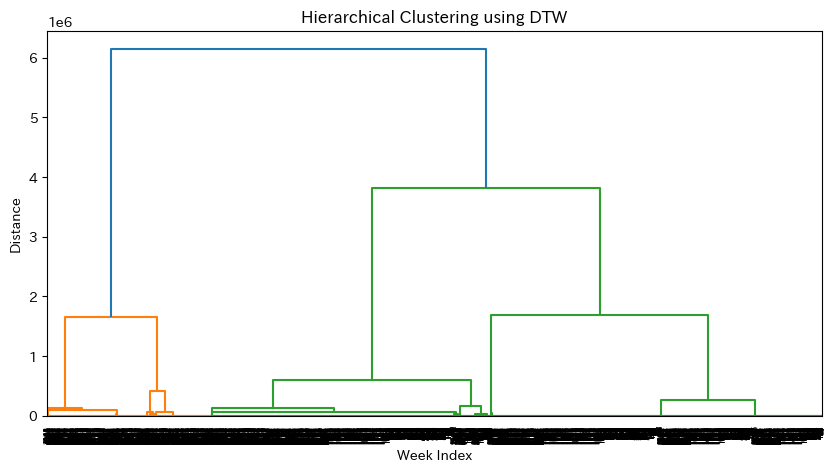

In [152]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 階層的クラスタリング
linkage_matrix = linkage(distance_matrix, method='ward')

# デンドログラムの描画
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering using DTW")
plt.xlabel("Week Index")
plt.ylabel("Distance")

  # ファイルに保存
# plt.tight_layout()
# plt.savefig("scatter_all_plots.png", dpi=300, bbox_inches="tight")
# plt.close()
# print("3つのグラフを1つのファイルに保存しました: scatter_all_plots.png")

plt.show()

In [153]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を設定（例: 3クラスタ）
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタラベルをデータフレームに追加
specific_df_sorted['cluster'] = cluster_labels

### シルエットスコア

In [154]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
print("シルエットスコア:", silhouette_avg)

シルエットスコア: 0.7675883763190617
